**Alex and Derek**

Spring 2025

CS 444: Deep Learning

#### Project 4: Transformers

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=4)

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

2025-05-12 22:20:38.147927: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-12 22:20:45.971980: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


![Some fun](images/transformer2.png)

## Task 5: Create GPT networks

With the Transformer Block and other network components implemented, let's build an actual transformer! We are implementing a transformer that follows the design of OpenAI's GPT line of neural networks. Therefore, the network class is called `GPT` (still inherits from `DeepNetwork` like usual). Specific GPT networks that you will construct will be child classes of `GPT` (much like `ResNet8` and `ResNet18` were child classes of `ResNet`).

### 5a. Building `GPTPico1`

Let's build a minimal GPT that consists of only one Transformer Block. This network, `GPTPico1`, has the following architecture:
1. Embedding layer
2. Positional encoding block.
3. Transformer block (1x)
4. Dense output layer

Implement and test the following required methods:
- `GPT`: constructor.
- `GPT`: `__call__` method. Forward pass through the transformer.
- `GPTPico1`: constructor. Assemble the net (*see above*).

In [2]:
from gpts import GPT, GPTPico1

#### Test: `loss` (temporal cross-entropy)

In [3]:
mygpt = GPT(seq_len=4, padding_char_enc=10)
mygpt.loss_name = 'temporal_cross_entropy'

tf.random.set_seed(1)
y_pred = tf.random.uniform(shape=(5, 4, 12), maxval=1, dtype=tf.float32)
y_true = tf.random.uniform(shape=(5, 4), maxval=11, dtype=tf.int32)

# Test 1: no masking the padding char
loss = mygpt.loss(y_pred, y_true, mask_padding_preds=False)
print(f'When not masking out the padding char, your loss is {loss.numpy():.4f} and it should be 0.9513.')
# Test 2: masking the padding char
loss = mygpt.loss(y_pred, y_true)
print(f'When masking out the padding char, your loss is {loss.numpy():.4f} and it should be 0.9442.')

2025-05-12 22:21:32.457039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20601 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9


When not masking out the padding char, your loss is 0.9513 and it should be 0.9513.


When masking out the padding char, your loss is 0.9442 and it should be 0.9442.


#### Test: `GPTPico1` architecture

In [4]:
mypicogpt = GPTPico1(vocab_sz=9, seq_len=15, padding_char_enc=5)
mypicogpt.compile(loss='temporal_cross_entropy')

---------------------------------------------------------------------------
Dense layer output(Output_Layer) shape: [1, 15, 9]
Transformer_Block_0:
	Transformer_Block_0_MLP:
	Dropout layer output(Transformer_Block_0_MLP_Dropout) shape: [1, 15, 24]
	Dense layer output(Transformer_Block_0_MLP_Dense2) shape: [1, 15, 24]
	Dense layer output(Transformer_Block_0_MLP_Dense1) shape: [1, 15, 96]
	Transformer_Block_0_MHA:
	Dropout layer output(Transformer_Block_0_MHA_Dropout) shape: [1, 15, 24]
	Dense layer output(Transformer_Block_0_MHA_Dense) shape: [1, 15, 24]
	Transformer_Block_0_MHA_Attention:
	Dropout layer output(attention_dropout) shape: [1, 4, 15, 15]
	Transformer_Block_0_MHA_QKV:
	Dense layer output(QKVBlock_Value) shape: [1, 15, 24]
	Dense layer output(QKVBlock_Key) shape: [1, 15, 24]
	Dense layer output(QKVBlock_Query) shape: [1, 15, 24]
Positional_Encoding_Block_0:
	Dropout layer output(Positional_Encoding_Block_0_Dropout) shape: [1, 15, 24]
	Positional encoding layer output(Positio

The above cell should print out:

```
---------------------------------------------------------------------------
Dense layer output(output) shape: [1, 15, 9]
TransformerBlock_0:
	TransformerBlock_0/MLP:
	Dropout layer output(TransformerBlock_0/MLP/dropout) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_1) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/MLP/dense_0) shape: [1, 15, 96]
	TransformerBlock_0/multihead_attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/dropout) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/dense_1) shape: [1, 15, 24]
	TransformerBlock_0/multihead_attention/attention:
	Dropout layer output(TransformerBlock_0/multihead_attention/attention/dropout) shape: [1, 4, 15, 15]
	TransformerBlock_0/multihead_attention/qkv_block:
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_v) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_k) shape: [1, 15, 24]
	Dense layer output(TransformerBlock_0/multihead_attention/qkv_block/dense_q) shape: [1, 15, 24]
PositionalEncodingBlock:
	Dropout layer output(PositionalEncodingBlock/dropout) shape: [1, 15, 24]
	Positional encoding layer output(PositionalEncodingBlock/positional_enc_layer) shape: [1, 15, 24]
Embedding layer output(EmbeddingLayer) shape: [1, 15, 24]
---------------------------------------------------------------------------
```

### 5b. `GPTPico1` overfit test

Let's verify that your `GPTPico1` works by overfitting a small amount of fake data.

Running the following cell should result in a training loss of ~`0.03` by 500 training epochs. The training loss after 1 epoch should be ~`5.0`.

In [5]:
tf.random.set_seed(0)
mypicogpt = GPTPico1(vocab_sz=100, seq_len=5, padding_char_enc=99)
mypicogpt.compile(loss='temporal_cross_entropy')

tf.random.set_seed(1)
x_dev_test = tf.random.uniform(shape=(10, 5), maxval=100, dtype=tf.int32)
y_dev_test = tf.random.uniform(shape=(10, 5), maxval=100, dtype=tf.int32)
train_loss_hist, _, _, _ = mypicogpt.fit(x_dev_test, y_dev_test, x_dev_test, y_dev_test, batch_size=10, max_epochs=500)

---------------------------------------------------------------------------
Dense layer output(Output_Layer) shape: [1, 5, 100]
Transformer_Block_0:
	Transformer_Block_0_MLP:
	Dropout layer output(Transformer_Block_0_MLP_Dropout) shape: [1, 5, 24]
	Dense layer output(Transformer_Block_0_MLP_Dense2) shape: [1, 5, 24]
	Dense layer output(Transformer_Block_0_MLP_Dense1) shape: [1, 5, 96]
	Transformer_Block_0_MHA:
	Dropout layer output(Transformer_Block_0_MHA_Dropout) shape: [1, 5, 24]
	Dense layer output(Transformer_Block_0_MHA_Dense) shape: [1, 5, 24]
	Transformer_Block_0_MHA_Attention:
	Dropout layer output(attention_dropout) shape: [1, 4, 5, 5]
	Transformer_Block_0_MHA_QKV:
	Dense layer output(QKVBlock_Value) shape: [1, 5, 24]
	Dense layer output(QKVBlock_Key) shape: [1, 5, 24]
	Dense layer output(QKVBlock_Query) shape: [1, 5, 24]
Positional_Encoding_Block_0:
	Dropout layer output(Positional_Encoding_Block_0_Dropout) shape: [1, 5, 24]
	Positional encoding layer output(Positional_Encodi

I0000 00:00:1747088513.426838     719 service.cc:145] XLA service 0x785d9c190de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747088513.426887     719 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9


2025-05-12 22:21:53.792174: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


2025-05-12 22:21:54.486008: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 90400


I0000 00:00:1747088515.054351     719 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Epoch 1/500: Train Loss: 4.9659, Val Loss: 5.0262, Val Acc: 0.0000, Time: 16.03s
Epoch 2/500: Train Loss: 5.1905, Val Loss: 4.9472, Val Acc: 0.0000, Time: 0.14s


Epoch 3/500: Train Loss: 4.7341, Val Loss: 4.8713, Val Acc: 0.0000, Time: 0.11s
Epoch 4/500: Train Loss: 4.7911, Val Loss: 4.7992, Val Acc: 0.0000, Time: 0.01s
Epoch 5/500: Train Loss: 4.8015, Val Loss: 4.7296, Val Acc: 0.0000, Time: 0.10s


Epoch 6/500: Train Loss: 4.7178, Val Loss: 4.6621, Val Acc: 0.0000, Time: 0.10s
Epoch 7/500: Train Loss: 4.7712, Val Loss: 4.5967, Val Acc: 0.0000, Time: 0.10s
Epoch 8/500: Train Loss: 4.5775, Val Loss: 4.5351, Val Acc: 0.0000, Time: 0.01s


Epoch 9/500: Train Loss: 4.4311, Val Loss: 4.4774, Val Acc: 0.0000, Time: 0.10s
Epoch 10/500: Train Loss: 4.3009, Val Loss: 4.4226, Val Acc: 0.0000, Time: 0.10s
Epoch 11/500: Train Loss: 4.3501, Val Loss: 4.3725, Val Acc: 0.0000, Time: 0.01s


Epoch 12/500: Train Loss: 4.1820, Val Loss: 4.3260, Val Acc: 0.0000, Time: 0.10s
Epoch 13/500: Train Loss: 4.3819, Val Loss: 4.2825, Val Acc: 0.0000, Time: 0.11s


Epoch 14/500: Train Loss: 4.2259, Val Loss: 4.2437, Val Acc: 0.0000, Time: 0.13s
Epoch 15/500: Train Loss: 4.1480, Val Loss: 4.2096, Val Acc: 0.0000, Time: 0.11s
Epoch 16/500: Train Loss: 4.2305, Val Loss: 4.1773, Val Acc: 0.0000, Time: 0.01s


Epoch 17/500: Train Loss: 4.2409, Val Loss: 4.1455, Val Acc: 0.0000, Time: 0.10s
Epoch 18/500: Train Loss: 4.4145, Val Loss: 4.1145, Val Acc: 0.0000, Time: 0.01s
Epoch 19/500: Train Loss: 4.1458, Val Loss: 4.0861, Val Acc: 0.0000, Time: 0.01s
Epoch 20/500: Train Loss: 4.1521, Val Loss: 4.0580, Val Acc: 0.0000, Time: 0.01s
Epoch 21/500: Train Loss: 3.9842, Val Loss: 4.0282, Val Acc: 0.0000, Time: 0.01s
Epoch 22/500: Train Loss: 4.0801, Val Loss: 3.9969, Val Acc: 0.0000, Time: 0.10s
Epoch 23/500: Train Loss: 3.8622, Val Loss: 3.9660, Val Acc: 0.0000, Time: 0.01s


Epoch 24/500: Train Loss: 3.8367, Val Loss: 3.9356, Val Acc: 0.0000, Time: 0.11s
Epoch 25/500: Train Loss: 3.7131, Val Loss: 3.9047, Val Acc: 0.0000, Time: 0.01s
Epoch 26/500: Train Loss: 3.9079, Val Loss: 3.8727, Val Acc: 0.0000, Time: 0.01s
Epoch 27/500: Train Loss: 4.0009, Val Loss: 3.8397, Val Acc: 0.0000, Time: 0.01s
Epoch 28/500: Train Loss: 3.7908, Val Loss: 3.8065, Val Acc: 0.0000, Time: 0.01s
Epoch 29/500: Train Loss: 3.6593, Val Loss: 3.7743, Val Acc: 0.0000, Time: 0.01s
Epoch 30/500: Train Loss: 3.9141, Val Loss: 3.7419, Val Acc: 0.0000, Time: 0.10s
Epoch 31/500: Train Loss: 3.8203, Val Loss: 3.7092, Val Acc: 0.0000, Time: 0.01s


Epoch 32/500: Train Loss: 3.5597, Val Loss: 3.6771, Val Acc: 0.0000, Time: 0.02s
Epoch 33/500: Train Loss: 3.6402, Val Loss: 3.6457, Val Acc: 0.0000, Time: 0.01s
Epoch 34/500: Train Loss: 3.7474, Val Loss: 3.6126, Val Acc: 0.0000, Time: 0.01s
Epoch 35/500: Train Loss: 3.8860, Val Loss: 3.5800, Val Acc: 0.0000, Time: 0.01s
Epoch 36/500: Train Loss: 3.6039, Val Loss: 3.5469, Val Acc: 0.0000, Time: 0.10s
Epoch 37/500: Train Loss: 3.5776, Val Loss: 3.5144, Val Acc: 0.0000, Time: 0.01s
Epoch 38/500: Train Loss: 3.5421, Val Loss: 3.4817, Val Acc: 0.0000, Time: 0.01s
Epoch 39/500: Train Loss: 3.4057, Val Loss: 3.4488, Val Acc: 0.0000, Time: 0.01s


Epoch 40/500: Train Loss: 3.3131, Val Loss: 3.4161, Val Acc: 0.0000, Time: 0.02s
Epoch 41/500: Train Loss: 3.3146, Val Loss: 3.3822, Val Acc: 0.0000, Time: 0.01s
Epoch 42/500: Train Loss: 3.2332, Val Loss: 3.3483, Val Acc: 0.0000, Time: 0.01s
Epoch 43/500: Train Loss: 3.2810, Val Loss: 3.3147, Val Acc: 0.0000, Time: 0.01s
Epoch 44/500: Train Loss: 3.3076, Val Loss: 3.2810, Val Acc: 0.0000, Time: 0.11s
Epoch 45/500: Train Loss: 3.1419, Val Loss: 3.2470, Val Acc: 0.0000, Time: 0.02s
Epoch 46/500: Train Loss: 3.2221, Val Loss: 3.2132, Val Acc: 0.0000, Time: 0.01s
Epoch 47/500: Train Loss: 3.2118, Val Loss: 3.1795, Val Acc: 0.0000, Time: 0.01s


Epoch 48/500: Train Loss: 3.0025, Val Loss: 3.1430, Val Acc: 0.0000, Time: 0.02s
Epoch 49/500: Train Loss: 3.1832, Val Loss: 3.1032, Val Acc: 0.0000, Time: 0.02s
Epoch 50/500: Train Loss: 3.3156, Val Loss: 3.0626, Val Acc: 0.0000, Time: 0.03s
Epoch 51/500: Train Loss: 3.1475, Val Loss: 3.0217, Val Acc: 0.0000, Time: 0.02s
Epoch 52/500: Train Loss: 3.1611, Val Loss: 2.9837, Val Acc: 0.0000, Time: 0.01s
Epoch 53/500: Train Loss: 2.9956, Val Loss: 2.9474, Val Acc: 0.0000, Time: 0.01s
Epoch 54/500: Train Loss: 3.0245, Val Loss: 2.9141, Val Acc: 0.0000, Time: 0.01s


Epoch 55/500: Train Loss: 2.7439, Val Loss: 2.8792, Val Acc: 0.0000, Time: 0.10s
Epoch 56/500: Train Loss: 2.7891, Val Loss: 2.8425, Val Acc: 0.0000, Time: 0.01s
Epoch 57/500: Train Loss: 2.7754, Val Loss: 2.8075, Val Acc: 0.0000, Time: 0.01s
Epoch 58/500: Train Loss: 2.7708, Val Loss: 2.7744, Val Acc: 0.0000, Time: 0.01s
Epoch 59/500: Train Loss: 2.8467, Val Loss: 2.7395, Val Acc: 0.0000, Time: 0.01s
Epoch 60/500: Train Loss: 2.7201, Val Loss: 2.7042, Val Acc: 0.0000, Time: 0.01s
Epoch 61/500: Train Loss: 2.7168, Val Loss: 2.6681, Val Acc: 0.0000, Time: 0.01s
Epoch 62/500: Train Loss: 2.6008, Val Loss: 2.6306, Val Acc: 0.0000, Time: 0.01s
Epoch 63/500: Train Loss: 2.8125, Val Loss: 2.5951, Val Acc: 0.0000, Time: 0.01s
Epoch 64/500: Train Loss: 2.4550, Val Loss: 2.5600, Val Acc: 0.0000, Time: 0.01s
Epoch 65/500: Train Loss: 2.5567, Val Loss: 2.5260, Val Acc: 0.0000, Time: 0.01s
Epoch 66/500: Train Loss: 2.7149, Val Loss: 2.4930, Val Acc: 0.0000, Time: 0.01s
Epoch 67/500: Train Loss: 2.

Epoch 69/500: Train Loss: 2.4816, Val Loss: 2.3971, Val Acc: 0.0000, Time: 0.02s
Epoch 70/500: Train Loss: 2.3431, Val Loss: 2.3690, Val Acc: 0.0000, Time: 0.02s
Epoch 71/500: Train Loss: 2.2895, Val Loss: 2.3359, Val Acc: 0.0000, Time: 0.01s
Epoch 72/500: Train Loss: 2.4421, Val Loss: 2.2969, Val Acc: 0.0000, Time: 0.02s
Epoch 73/500: Train Loss: 2.2935, Val Loss: 2.2611, Val Acc: 0.0000, Time: 0.02s
Epoch 74/500: Train Loss: 2.2563, Val Loss: 2.2292, Val Acc: 0.0000, Time: 0.01s
Epoch 75/500: Train Loss: 2.2939, Val Loss: 2.2019, Val Acc: 0.0000, Time: 0.01s
Epoch 76/500: Train Loss: 2.1845, Val Loss: 2.1767, Val Acc: 0.0000, Time: 0.01s


Epoch 77/500: Train Loss: 2.3817, Val Loss: 2.1513, Val Acc: 0.0000, Time: 0.10s
Epoch 78/500: Train Loss: 2.1046, Val Loss: 2.1201, Val Acc: 0.0000, Time: 0.01s
Epoch 79/500: Train Loss: 2.1455, Val Loss: 2.0838, Val Acc: 0.0000, Time: 0.01s
Epoch 80/500: Train Loss: 1.9957, Val Loss: 2.0455, Val Acc: 0.0000, Time: 0.01s
Epoch 81/500: Train Loss: 2.0970, Val Loss: 2.0130, Val Acc: 0.0000, Time: 0.01s
Epoch 82/500: Train Loss: 2.0905, Val Loss: 1.9858, Val Acc: 0.0000, Time: 0.01s
Epoch 83/500: Train Loss: 1.8754, Val Loss: 1.9593, Val Acc: 0.0000, Time: 0.01s
Epoch 84/500: Train Loss: 2.1142, Val Loss: 1.9267, Val Acc: 0.0000, Time: 0.01s
Epoch 85/500: Train Loss: 1.8189, Val Loss: 1.8947, Val Acc: 0.0000, Time: 0.01s
Epoch 86/500: Train Loss: 1.9101, Val Loss: 1.8641, Val Acc: 0.0000, Time: 0.01s
Epoch 87/500: Train Loss: 1.8544, Val Loss: 1.8338, Val Acc: 0.0000, Time: 0.01s
Epoch 88/500: Train Loss: 1.7747, Val Loss: 1.8043, Val Acc: 0.0000, Time: 0.01s
Epoch 89/500: Train Loss: 1.

Epoch 92/500: Train Loss: 1.7142, Val Loss: 1.6771, Val Acc: 0.0000, Time: 0.01s
Epoch 93/500: Train Loss: 1.7094, Val Loss: 1.6421, Val Acc: 0.0000, Time: 0.01s
Epoch 94/500: Train Loss: 1.6257, Val Loss: 1.6108, Val Acc: 0.0000, Time: 0.01s
Epoch 95/500: Train Loss: 1.6078, Val Loss: 1.5841, Val Acc: 0.0000, Time: 0.01s
Epoch 96/500: Train Loss: 1.5820, Val Loss: 1.5542, Val Acc: 0.0000, Time: 0.03s
Epoch 97/500: Train Loss: 1.4887, Val Loss: 1.5233, Val Acc: 0.0000, Time: 0.02s
Epoch 98/500: Train Loss: 1.4912, Val Loss: 1.4975, Val Acc: 0.0000, Time: 0.01s
Epoch 99/500: Train Loss: 1.6660, Val Loss: 1.4737, Val Acc: 0.0000, Time: 0.01s
Epoch 100/500: Train Loss: 1.5660, Val Loss: 1.4459, Val Acc: 0.0000, Time: 0.01s
Epoch 101/500: Train Loss: 1.4056, Val Loss: 1.4144, Val Acc: 0.0000, Time: 0.01s
Epoch 102/500: Train Loss: 1.4228, Val Loss: 1.3853, Val Acc: 0.0000, Time: 0.01s
Epoch 103/500: Train Loss: 1.3297, Val Loss: 1.3639, Val Acc: 0.0000, Time: 0.01s
Epoch 104/500: Train Los

Epoch 106/500: Train Loss: 1.3161, Val Loss: 1.2891, Val Acc: 0.0000, Time: 0.01s
Epoch 107/500: Train Loss: 1.3895, Val Loss: 1.2671, Val Acc: 0.0000, Time: 0.01s
Epoch 108/500: Train Loss: 1.4428, Val Loss: 1.2414, Val Acc: 0.0000, Time: 0.01s
Epoch 109/500: Train Loss: 1.2888, Val Loss: 1.2128, Val Acc: 0.0000, Time: 0.01s
Epoch 110/500: Train Loss: 1.0960, Val Loss: 1.1876, Val Acc: 0.0000, Time: 0.01s
Epoch 111/500: Train Loss: 1.0770, Val Loss: 1.1672, Val Acc: 0.0000, Time: 0.01s
Epoch 112/500: Train Loss: 0.9720, Val Loss: 1.1454, Val Acc: 0.0000, Time: 0.01s
Epoch 113/500: Train Loss: 1.2255, Val Loss: 1.1205, Val Acc: 0.0000, Time: 0.01s
Epoch 114/500: Train Loss: 1.1561, Val Loss: 1.0978, Val Acc: 0.0000, Time: 0.01s
Epoch 115/500: Train Loss: 0.9364, Val Loss: 1.0816, Val Acc: 0.0000, Time: 0.01s
Epoch 116/500: Train Loss: 1.1353, Val Loss: 1.0655, Val Acc: 0.0000, Time: 0.01s
Epoch 117/500: Train Loss: 1.0566, Val Loss: 1.0461, Val Acc: 0.0000, Time: 0.01s
Epoch 118/500: T

Epoch 122/500: Train Loss: 0.9678, Val Loss: 0.9471, Val Acc: 0.0000, Time: 0.01s
Epoch 123/500: Train Loss: 0.8830, Val Loss: 0.9290, Val Acc: 0.0000, Time: 0.01s
Epoch 124/500: Train Loss: 0.8914, Val Loss: 0.9108, Val Acc: 0.0000, Time: 0.01s
Epoch 125/500: Train Loss: 0.8595, Val Loss: 0.8911, Val Acc: 0.0000, Time: 0.01s
Epoch 126/500: Train Loss: 0.9635, Val Loss: 0.8714, Val Acc: 0.0000, Time: 0.01s
Epoch 127/500: Train Loss: 0.8350, Val Loss: 0.8558, Val Acc: 0.0000, Time: 0.01s
Epoch 128/500: Train Loss: 0.8405, Val Loss: 0.8424, Val Acc: 0.0000, Time: 0.01s
Epoch 129/500: Train Loss: 0.7466, Val Loss: 0.8268, Val Acc: 0.0000, Time: 0.01s
Epoch 130/500: Train Loss: 0.7732, Val Loss: 0.8101, Val Acc: 0.0000, Time: 0.01s
Epoch 131/500: Train Loss: 0.7999, Val Loss: 0.7953, Val Acc: 0.0000, Time: 0.01s
Epoch 132/500: Train Loss: 0.8894, Val Loss: 0.7789, Val Acc: 0.0000, Time: 0.01s
Epoch 133/500: Train Loss: 0.7956, Val Loss: 0.7629, Val Acc: 0.0000, Time: 0.01s
Epoch 134/500: T

Epoch 138/500: Train Loss: 0.6145, Val Loss: 0.6902, Val Acc: 0.0000, Time: 0.01s
Epoch 139/500: Train Loss: 0.7717, Val Loss: 0.6790, Val Acc: 0.0000, Time: 0.01s
Epoch 140/500: Train Loss: 0.6344, Val Loss: 0.6662, Val Acc: 0.0000, Time: 0.01s
Epoch 141/500: Train Loss: 0.7350, Val Loss: 0.6518, Val Acc: 0.0000, Time: 0.01s
Epoch 142/500: Train Loss: 0.6883, Val Loss: 0.6381, Val Acc: 0.0000, Time: 0.01s
Epoch 143/500: Train Loss: 0.6273, Val Loss: 0.6258, Val Acc: 0.0000, Time: 0.01s
Epoch 144/500: Train Loss: 0.6278, Val Loss: 0.6134, Val Acc: 0.0000, Time: 0.01s
Epoch 145/500: Train Loss: 0.5952, Val Loss: 0.6009, Val Acc: 0.0000, Time: 0.02s
Epoch 146/500: Train Loss: 0.5407, Val Loss: 0.5882, Val Acc: 0.0000, Time: 0.01s
Epoch 147/500: Train Loss: 0.5360, Val Loss: 0.5760, Val Acc: 0.0000, Time: 0.01s
Epoch 148/500: Train Loss: 0.5594, Val Loss: 0.5646, Val Acc: 0.0000, Time: 0.01s
Epoch 149/500: Train Loss: 0.6260, Val Loss: 0.5535, Val Acc: 0.0000, Time: 0.02s
Epoch 150/500: T

Epoch 152/500: Train Loss: 0.6109, Val Loss: 0.5246, Val Acc: 0.0000, Time: 0.02s
Epoch 153/500: Train Loss: 0.5246, Val Loss: 0.5136, Val Acc: 0.0000, Time: 0.01s
Epoch 154/500: Train Loss: 0.5094, Val Loss: 0.5033, Val Acc: 0.0000, Time: 0.01s
Epoch 155/500: Train Loss: 0.5262, Val Loss: 0.4939, Val Acc: 0.0000, Time: 0.01s
Epoch 156/500: Train Loss: 0.5057, Val Loss: 0.4850, Val Acc: 0.0000, Time: 0.01s
Epoch 157/500: Train Loss: 0.5433, Val Loss: 0.4760, Val Acc: 0.0000, Time: 0.01s
Epoch 158/500: Train Loss: 0.4762, Val Loss: 0.4671, Val Acc: 0.0000, Time: 0.01s
Epoch 159/500: Train Loss: 0.4110, Val Loss: 0.4588, Val Acc: 0.0000, Time: 0.01s
Epoch 160/500: Train Loss: 0.4845, Val Loss: 0.4509, Val Acc: 0.0000, Time: 0.01s
Epoch 161/500: Train Loss: 0.4263, Val Loss: 0.4428, Val Acc: 0.0000, Time: 0.01s
Epoch 162/500: Train Loss: 0.4251, Val Loss: 0.4348, Val Acc: 0.0000, Time: 0.01s
Epoch 163/500: Train Loss: 0.4408, Val Loss: 0.4268, Val Acc: 0.0000, Time: 0.01s
Epoch 164/500: T

Epoch 167/500: Train Loss: 0.4351, Val Loss: 0.3965, Val Acc: 0.0000, Time: 0.02s
Epoch 168/500: Train Loss: 0.3841, Val Loss: 0.3894, Val Acc: 0.0000, Time: 0.01s
Epoch 169/500: Train Loss: 0.3338, Val Loss: 0.3829, Val Acc: 0.0000, Time: 0.01s
Epoch 170/500: Train Loss: 0.4009, Val Loss: 0.3764, Val Acc: 0.0000, Time: 0.01s
Epoch 171/500: Train Loss: 0.3301, Val Loss: 0.3702, Val Acc: 0.0000, Time: 0.01s
Epoch 172/500: Train Loss: 0.3804, Val Loss: 0.3642, Val Acc: 0.0000, Time: 0.01s
Epoch 173/500: Train Loss: 0.3717, Val Loss: 0.3582, Val Acc: 0.0000, Time: 0.01s
Epoch 174/500: Train Loss: 0.3567, Val Loss: 0.3523, Val Acc: 0.0000, Time: 0.01s
Epoch 175/500: Train Loss: 0.3365, Val Loss: 0.3466, Val Acc: 0.0000, Time: 0.01s
Epoch 176/500: Train Loss: 0.3180, Val Loss: 0.3411, Val Acc: 0.0000, Time: 0.01s
Epoch 177/500: Train Loss: 0.3495, Val Loss: 0.3358, Val Acc: 0.0000, Time: 0.01s
Epoch 178/500: Train Loss: 0.3502, Val Loss: 0.3306, Val Acc: 0.0000, Time: 0.01s


Epoch 179/500: Train Loss: 0.3414, Val Loss: 0.3253, Val Acc: 0.0000, Time: 0.11s
Epoch 180/500: Train Loss: 0.3361, Val Loss: 0.3199, Val Acc: 0.0000, Time: 0.02s
Epoch 181/500: Train Loss: 0.3090, Val Loss: 0.3150, Val Acc: 0.0000, Time: 0.01s
Epoch 182/500: Train Loss: 0.2893, Val Loss: 0.3103, Val Acc: 0.0000, Time: 0.01s
Epoch 183/500: Train Loss: 0.3079, Val Loss: 0.3057, Val Acc: 0.0000, Time: 0.01s
Epoch 184/500: Train Loss: 0.3006, Val Loss: 0.3011, Val Acc: 0.0000, Time: 0.01s
Epoch 185/500: Train Loss: 0.2871, Val Loss: 0.2965, Val Acc: 0.0000, Time: 0.01s
Epoch 186/500: Train Loss: 0.2938, Val Loss: 0.2921, Val Acc: 0.0000, Time: 0.01s
Epoch 187/500: Train Loss: 0.3165, Val Loss: 0.2878, Val Acc: 0.0000, Time: 0.01s
Epoch 188/500: Train Loss: 0.2782, Val Loss: 0.2835, Val Acc: 0.0000, Time: 0.01s
Epoch 189/500: Train Loss: 0.2568, Val Loss: 0.2794, Val Acc: 0.0000, Time: 0.01s
Epoch 190/500: Train Loss: 0.2971, Val Loss: 0.2753, Val Acc: 0.0000, Time: 0.01s
Epoch 191/500: T

Epoch 194/500: Train Loss: 0.2616, Val Loss: 0.2596, Val Acc: 0.0000, Time: 0.01s
Epoch 195/500: Train Loss: 0.2477, Val Loss: 0.2559, Val Acc: 0.0000, Time: 0.01s
Epoch 196/500: Train Loss: 0.2507, Val Loss: 0.2524, Val Acc: 0.0000, Time: 0.01s
Epoch 197/500: Train Loss: 0.2818, Val Loss: 0.2489, Val Acc: 0.0000, Time: 0.01s
Epoch 198/500: Train Loss: 0.2489, Val Loss: 0.2453, Val Acc: 0.0000, Time: 0.01s
Epoch 199/500: Train Loss: 0.2417, Val Loss: 0.2418, Val Acc: 0.0000, Time: 0.01s
Epoch 200/500: Train Loss: 0.2440, Val Loss: 0.2384, Val Acc: 0.0000, Time: 0.01s
Epoch 201/500: Train Loss: 0.2411, Val Loss: 0.2351, Val Acc: 0.0000, Time: 0.01s
Epoch 202/500: Train Loss: 0.2340, Val Loss: 0.2319, Val Acc: 0.0000, Time: 0.01s
Epoch 203/500: Train Loss: 0.2090, Val Loss: 0.2288, Val Acc: 0.0000, Time: 0.01s
Epoch 204/500: Train Loss: 0.2372, Val Loss: 0.2257, Val Acc: 0.0000, Time: 0.01s
Epoch 205/500: Train Loss: 0.2301, Val Loss: 0.2226, Val Acc: 0.0000, Time: 0.01s
Epoch 206/500: T

Epoch 209/500: Train Loss: 0.2219, Val Loss: 0.2113, Val Acc: 0.0000, Time: 0.01s
Epoch 210/500: Train Loss: 0.2290, Val Loss: 0.2087, Val Acc: 0.0000, Time: 0.01s
Epoch 211/500: Train Loss: 0.1995, Val Loss: 0.2061, Val Acc: 0.0000, Time: 0.01s
Epoch 212/500: Train Loss: 0.1874, Val Loss: 0.2034, Val Acc: 0.0000, Time: 0.01s
Epoch 213/500: Train Loss: 0.2102, Val Loss: 0.2008, Val Acc: 0.0000, Time: 0.01s
Epoch 214/500: Train Loss: 0.1914, Val Loss: 0.1984, Val Acc: 0.0000, Time: 0.01s
Epoch 215/500: Train Loss: 0.2080, Val Loss: 0.1960, Val Acc: 0.0000, Time: 0.01s
Epoch 216/500: Train Loss: 0.1781, Val Loss: 0.1935, Val Acc: 0.0000, Time: 0.01s
Epoch 217/500: Train Loss: 0.1779, Val Loss: 0.1911, Val Acc: 0.0000, Time: 0.01s
Epoch 218/500: Train Loss: 0.1793, Val Loss: 0.1889, Val Acc: 0.0000, Time: 0.01s
Epoch 219/500: Train Loss: 0.2018, Val Loss: 0.1866, Val Acc: 0.0000, Time: 0.01s
Epoch 220/500: Train Loss: 0.1857, Val Loss: 0.1844, Val Acc: 0.0000, Time: 0.01s
Epoch 221/500: T

Epoch 224/500: Train Loss: 0.1953, Val Loss: 0.1762, Val Acc: 0.0000, Time: 0.01s
Epoch 225/500: Train Loss: 0.1659, Val Loss: 0.1742, Val Acc: 0.0000, Time: 0.01s
Epoch 226/500: Train Loss: 0.1633, Val Loss: 0.1724, Val Acc: 0.0000, Time: 0.01s
Epoch 227/500: Train Loss: 0.1631, Val Loss: 0.1705, Val Acc: 0.0000, Time: 0.01s
Epoch 228/500: Train Loss: 0.1531, Val Loss: 0.1687, Val Acc: 0.0000, Time: 0.01s
Epoch 229/500: Train Loss: 0.1594, Val Loss: 0.1669, Val Acc: 0.0000, Time: 0.01s
Epoch 230/500: Train Loss: 0.1682, Val Loss: 0.1651, Val Acc: 0.0000, Time: 0.01s
Epoch 231/500: Train Loss: 0.1611, Val Loss: 0.1634, Val Acc: 0.0000, Time: 0.01s
Epoch 232/500: Train Loss: 0.1560, Val Loss: 0.1616, Val Acc: 0.0000, Time: 0.01s
Epoch 233/500: Train Loss: 0.1517, Val Loss: 0.1600, Val Acc: 0.0000, Time: 0.01s
Epoch 234/500: Train Loss: 0.1607, Val Loss: 0.1583, Val Acc: 0.0000, Time: 0.01s
Epoch 235/500: Train Loss: 0.1446, Val Loss: 0.1567, Val Acc: 0.0000, Time: 0.01s
Epoch 236/500: T

Epoch 239/500: Train Loss: 0.1595, Val Loss: 0.1504, Val Acc: 0.0000, Time: 0.01s
Epoch 240/500: Train Loss: 0.1616, Val Loss: 0.1489, Val Acc: 0.0000, Time: 0.01s
Epoch 241/500: Train Loss: 0.1686, Val Loss: 0.1473, Val Acc: 0.0000, Time: 0.01s
Epoch 242/500: Train Loss: 0.1502, Val Loss: 0.1458, Val Acc: 0.0000, Time: 0.01s
Epoch 243/500: Train Loss: 0.1581, Val Loss: 0.1443, Val Acc: 0.0000, Time: 0.01s
Epoch 244/500: Train Loss: 0.1545, Val Loss: 0.1428, Val Acc: 0.0000, Time: 0.02s
Epoch 245/500: Train Loss: 0.1416, Val Loss: 0.1413, Val Acc: 0.0000, Time: 0.01s
Epoch 246/500: Train Loss: 0.1318, Val Loss: 0.1399, Val Acc: 0.0000, Time: 0.01s
Epoch 247/500: Train Loss: 0.1502, Val Loss: 0.1385, Val Acc: 0.0000, Time: 0.01s
Epoch 248/500: Train Loss: 0.1354, Val Loss: 0.1372, Val Acc: 0.0000, Time: 0.01s
Epoch 249/500: Train Loss: 0.1370, Val Loss: 0.1358, Val Acc: 0.0000, Time: 0.01s
Epoch 250/500: Train Loss: 0.1366, Val Loss: 0.1345, Val Acc: 0.0000, Time: 0.01s
Epoch 251/500: T

Epoch 254/500: Train Loss: 0.1289, Val Loss: 0.1295, Val Acc: 0.0000, Time: 0.01s
Epoch 255/500: Train Loss: 0.1220, Val Loss: 0.1283, Val Acc: 0.0000, Time: 0.01s
Epoch 256/500: Train Loss: 0.1296, Val Loss: 0.1271, Val Acc: 0.0000, Time: 0.02s
Epoch 257/500: Train Loss: 0.1186, Val Loss: 0.1259, Val Acc: 0.0000, Time: 0.01s
Epoch 258/500: Train Loss: 0.1259, Val Loss: 0.1248, Val Acc: 0.0000, Time: 0.01s
Epoch 259/500: Train Loss: 0.1348, Val Loss: 0.1237, Val Acc: 0.0000, Time: 0.01s
Epoch 260/500: Train Loss: 0.1353, Val Loss: 0.1226, Val Acc: 0.0000, Time: 0.01s
Epoch 261/500: Train Loss: 0.1132, Val Loss: 0.1215, Val Acc: 0.0000, Time: 0.01s
Epoch 262/500: Train Loss: 0.1124, Val Loss: 0.1205, Val Acc: 0.0000, Time: 0.01s
Epoch 263/500: Train Loss: 0.1120, Val Loss: 0.1195, Val Acc: 0.0000, Time: 0.01s
Epoch 264/500: Train Loss: 0.1171, Val Loss: 0.1185, Val Acc: 0.0000, Time: 0.01s
Epoch 265/500: Train Loss: 0.1244, Val Loss: 0.1175, Val Acc: 0.0000, Time: 0.01s
Epoch 266/500: T

Epoch 269/500: Train Loss: 0.1190, Val Loss: 0.1135, Val Acc: 0.0000, Time: 0.01s
Epoch 270/500: Train Loss: 0.1212, Val Loss: 0.1125, Val Acc: 0.0000, Time: 0.01s
Epoch 271/500: Train Loss: 0.1005, Val Loss: 0.1116, Val Acc: 0.0000, Time: 0.01s
Epoch 272/500: Train Loss: 0.1171, Val Loss: 0.1106, Val Acc: 0.0000, Time: 0.01s
Epoch 273/500: Train Loss: 0.1198, Val Loss: 0.1097, Val Acc: 0.0000, Time: 0.01s
Epoch 274/500: Train Loss: 0.1039, Val Loss: 0.1089, Val Acc: 0.0000, Time: 0.01s
Epoch 275/500: Train Loss: 0.1079, Val Loss: 0.1080, Val Acc: 0.0000, Time: 0.01s
Epoch 276/500: Train Loss: 0.1162, Val Loss: 0.1071, Val Acc: 0.0000, Time: 0.01s
Epoch 277/500: Train Loss: 0.1058, Val Loss: 0.1063, Val Acc: 0.0000, Time: 0.01s
Epoch 278/500: Train Loss: 0.1155, Val Loss: 0.1054, Val Acc: 0.0000, Time: 0.01s
Epoch 279/500: Train Loss: 0.1136, Val Loss: 0.1046, Val Acc: 0.0000, Time: 0.01s
Epoch 280/500: Train Loss: 0.0982, Val Loss: 0.1038, Val Acc: 0.0000, Time: 0.01s
Epoch 281/500: T

Epoch 284/500: Train Loss: 0.0976, Val Loss: 0.1005, Val Acc: 0.0000, Time: 0.02s
Epoch 285/500: Train Loss: 0.1074, Val Loss: 0.0997, Val Acc: 0.0000, Time: 0.01s
Epoch 286/500: Train Loss: 0.0989, Val Loss: 0.0989, Val Acc: 0.0000, Time: 0.01s
Epoch 287/500: Train Loss: 0.0994, Val Loss: 0.0981, Val Acc: 0.0000, Time: 0.01s
Epoch 288/500: Train Loss: 0.0938, Val Loss: 0.0973, Val Acc: 0.0000, Time: 0.01s
Epoch 289/500: Train Loss: 0.0904, Val Loss: 0.0966, Val Acc: 0.0000, Time: 0.01s
Epoch 290/500: Train Loss: 0.0993, Val Loss: 0.0958, Val Acc: 0.0000, Time: 0.01s
Epoch 291/500: Train Loss: 0.0993, Val Loss: 0.0951, Val Acc: 0.0000, Time: 0.01s
Epoch 292/500: Train Loss: 0.0995, Val Loss: 0.0944, Val Acc: 0.0000, Time: 0.01s
Epoch 293/500: Train Loss: 0.0964, Val Loss: 0.0937, Val Acc: 0.0000, Time: 0.01s
Epoch 294/500: Train Loss: 0.0874, Val Loss: 0.0930, Val Acc: 0.0000, Time: 0.01s
Epoch 295/500: Train Loss: 0.0999, Val Loss: 0.0923, Val Acc: 0.0000, Time: 0.01s
Epoch 296/500: T

Epoch 299/500: Train Loss: 0.0872, Val Loss: 0.0896, Val Acc: 0.0000, Time: 0.01s
Epoch 300/500: Train Loss: 0.0903, Val Loss: 0.0889, Val Acc: 0.0000, Time: 0.01s
Epoch 301/500: Train Loss: 0.0902, Val Loss: 0.0883, Val Acc: 0.0000, Time: 0.01s
Epoch 302/500: Train Loss: 0.0891, Val Loss: 0.0877, Val Acc: 0.0000, Time: 0.01s
Epoch 303/500: Train Loss: 0.0811, Val Loss: 0.0871, Val Acc: 0.0000, Time: 0.01s
Epoch 304/500: Train Loss: 0.0835, Val Loss: 0.0865, Val Acc: 0.0000, Time: 0.01s
Epoch 305/500: Train Loss: 0.0851, Val Loss: 0.0859, Val Acc: 0.0000, Time: 0.01s
Epoch 306/500: Train Loss: 0.0806, Val Loss: 0.0853, Val Acc: 0.0000, Time: 0.01s
Epoch 307/500: Train Loss: 0.0794, Val Loss: 0.0847, Val Acc: 0.0000, Time: 0.01s
Epoch 308/500: Train Loss: 0.0862, Val Loss: 0.0841, Val Acc: 0.0000, Time: 0.01s
Epoch 309/500: Train Loss: 0.0898, Val Loss: 0.0836, Val Acc: 0.0000, Time: 0.01s
Epoch 310/500: Train Loss: 0.0886, Val Loss: 0.0830, Val Acc: 0.0000, Time: 0.01s
Epoch 311/500: T

Epoch 314/500: Train Loss: 0.0744, Val Loss: 0.0807, Val Acc: 0.0000, Time: 0.01s
Epoch 315/500: Train Loss: 0.0824, Val Loss: 0.0802, Val Acc: 0.0000, Time: 0.01s
Epoch 316/500: Train Loss: 0.0813, Val Loss: 0.0797, Val Acc: 0.0000, Time: 0.01s
Epoch 317/500: Train Loss: 0.0756, Val Loss: 0.0792, Val Acc: 0.0000, Time: 0.01s
Epoch 318/500: Train Loss: 0.0773, Val Loss: 0.0786, Val Acc: 0.0000, Time: 0.01s
Epoch 319/500: Train Loss: 0.0781, Val Loss: 0.0781, Val Acc: 0.0000, Time: 0.01s
Epoch 320/500: Train Loss: 0.0759, Val Loss: 0.0776, Val Acc: 0.0000, Time: 0.01s
Epoch 321/500: Train Loss: 0.0745, Val Loss: 0.0771, Val Acc: 0.0000, Time: 0.01s
Epoch 322/500: Train Loss: 0.0768, Val Loss: 0.0766, Val Acc: 0.0000, Time: 0.01s
Epoch 323/500: Train Loss: 0.0857, Val Loss: 0.0761, Val Acc: 0.0000, Time: 0.01s
Epoch 324/500: Train Loss: 0.0805, Val Loss: 0.0756, Val Acc: 0.0000, Time: 0.01s
Epoch 325/500: Train Loss: 0.0771, Val Loss: 0.0751, Val Acc: 0.0000, Time: 0.01s
Epoch 326/500: T

Epoch 329/500: Train Loss: 0.0722, Val Loss: 0.0732, Val Acc: 0.0000, Time: 0.02s
Epoch 330/500: Train Loss: 0.0675, Val Loss: 0.0727, Val Acc: 0.0000, Time: 0.02s
Epoch 331/500: Train Loss: 0.0712, Val Loss: 0.0723, Val Acc: 0.0000, Time: 0.01s
Epoch 332/500: Train Loss: 0.0757, Val Loss: 0.0718, Val Acc: 0.0000, Time: 0.01s
Epoch 333/500: Train Loss: 0.0630, Val Loss: 0.0714, Val Acc: 0.0000, Time: 0.01s
Epoch 334/500: Train Loss: 0.0760, Val Loss: 0.0709, Val Acc: 0.0000, Time: 0.01s
Epoch 335/500: Train Loss: 0.0756, Val Loss: 0.0705, Val Acc: 0.0000, Time: 0.01s
Epoch 336/500: Train Loss: 0.0740, Val Loss: 0.0700, Val Acc: 0.0000, Time: 0.01s
Epoch 337/500: Train Loss: 0.0714, Val Loss: 0.0696, Val Acc: 0.0000, Time: 0.01s
Epoch 338/500: Train Loss: 0.0652, Val Loss: 0.0692, Val Acc: 0.0000, Time: 0.01s
Epoch 339/500: Train Loss: 0.0681, Val Loss: 0.0687, Val Acc: 0.0000, Time: 0.01s
Epoch 340/500: Train Loss: 0.0752, Val Loss: 0.0683, Val Acc: 0.0000, Time: 0.01s
Epoch 341/500: T

Epoch 344/500: Train Loss: 0.0698, Val Loss: 0.0667, Val Acc: 0.0000, Time: 0.01s
Epoch 345/500: Train Loss: 0.0587, Val Loss: 0.0663, Val Acc: 0.0000, Time: 0.01s
Epoch 346/500: Train Loss: 0.0646, Val Loss: 0.0659, Val Acc: 0.0000, Time: 0.01s
Epoch 347/500: Train Loss: 0.0685, Val Loss: 0.0655, Val Acc: 0.0000, Time: 0.01s
Epoch 348/500: Train Loss: 0.0586, Val Loss: 0.0651, Val Acc: 0.0000, Time: 0.01s
Epoch 349/500: Train Loss: 0.0765, Val Loss: 0.0647, Val Acc: 0.0000, Time: 0.01s
Epoch 350/500: Train Loss: 0.0684, Val Loss: 0.0643, Val Acc: 0.0000, Time: 0.01s
Epoch 351/500: Train Loss: 0.0673, Val Loss: 0.0640, Val Acc: 0.0000, Time: 0.01s
Epoch 352/500: Train Loss: 0.0581, Val Loss: 0.0636, Val Acc: 0.0000, Time: 0.01s
Epoch 353/500: Train Loss: 0.0643, Val Loss: 0.0632, Val Acc: 0.0000, Time: 0.01s
Epoch 354/500: Train Loss: 0.0662, Val Loss: 0.0628, Val Acc: 0.0000, Time: 0.01s
Epoch 355/500: Train Loss: 0.0610, Val Loss: 0.0625, Val Acc: 0.0000, Time: 0.01s
Epoch 356/500: T

Epoch 359/500: Train Loss: 0.0616, Val Loss: 0.0610, Val Acc: 0.0000, Time: 0.02s
Epoch 360/500: Train Loss: 0.0636, Val Loss: 0.0607, Val Acc: 0.0000, Time: 0.01s
Epoch 361/500: Train Loss: 0.0602, Val Loss: 0.0604, Val Acc: 0.0000, Time: 0.01s
Epoch 362/500: Train Loss: 0.0611, Val Loss: 0.0600, Val Acc: 0.0000, Time: 0.01s
Epoch 363/500: Train Loss: 0.0566, Val Loss: 0.0597, Val Acc: 0.0000, Time: 0.01s
Epoch 364/500: Train Loss: 0.0597, Val Loss: 0.0594, Val Acc: 0.0000, Time: 0.01s
Epoch 365/500: Train Loss: 0.0622, Val Loss: 0.0590, Val Acc: 0.0000, Time: 0.01s
Epoch 366/500: Train Loss: 0.0591, Val Loss: 0.0587, Val Acc: 0.0000, Time: 0.01s
Epoch 367/500: Train Loss: 0.0628, Val Loss: 0.0584, Val Acc: 0.0000, Time: 0.01s
Epoch 368/500: Train Loss: 0.0579, Val Loss: 0.0580, Val Acc: 0.0000, Time: 0.01s
Epoch 369/500: Train Loss: 0.0575, Val Loss: 0.0577, Val Acc: 0.0000, Time: 0.01s
Epoch 370/500: Train Loss: 0.0570, Val Loss: 0.0574, Val Acc: 0.0000, Time: 0.01s
Epoch 371/500: T

Epoch 374/500: Train Loss: 0.0561, Val Loss: 0.0562, Val Acc: 0.0000, Time: 0.01s
Epoch 375/500: Train Loss: 0.0570, Val Loss: 0.0559, Val Acc: 0.0000, Time: 0.01s
Epoch 376/500: Train Loss: 0.0544, Val Loss: 0.0556, Val Acc: 0.0000, Time: 0.01s
Epoch 377/500: Train Loss: 0.0513, Val Loss: 0.0553, Val Acc: 0.0000, Time: 0.01s
Epoch 378/500: Train Loss: 0.0573, Val Loss: 0.0550, Val Acc: 0.0000, Time: 0.01s
Epoch 379/500: Train Loss: 0.0502, Val Loss: 0.0548, Val Acc: 0.0000, Time: 0.01s
Epoch 380/500: Train Loss: 0.0536, Val Loss: 0.0545, Val Acc: 0.0000, Time: 0.01s
Epoch 381/500: Train Loss: 0.0554, Val Loss: 0.0542, Val Acc: 0.0000, Time: 0.01s
Epoch 382/500: Train Loss: 0.0557, Val Loss: 0.0539, Val Acc: 0.0000, Time: 0.01s
Epoch 383/500: Train Loss: 0.0578, Val Loss: 0.0536, Val Acc: 0.0000, Time: 0.01s
Epoch 384/500: Train Loss: 0.0554, Val Loss: 0.0533, Val Acc: 0.0000, Time: 0.01s
Epoch 385/500: Train Loss: 0.0522, Val Loss: 0.0531, Val Acc: 0.0000, Time: 0.01s
Epoch 386/500: T

Epoch 389/500: Train Loss: 0.0489, Val Loss: 0.0520, Val Acc: 0.0000, Time: 0.01s
Epoch 390/500: Train Loss: 0.0529, Val Loss: 0.0517, Val Acc: 0.0000, Time: 0.01s
Epoch 391/500: Train Loss: 0.0517, Val Loss: 0.0515, Val Acc: 0.0000, Time: 0.01s
Epoch 392/500: Train Loss: 0.0483, Val Loss: 0.0512, Val Acc: 0.0000, Time: 0.01s
Epoch 393/500: Train Loss: 0.0501, Val Loss: 0.0510, Val Acc: 0.0000, Time: 0.01s
Epoch 394/500: Train Loss: 0.0542, Val Loss: 0.0507, Val Acc: 0.0000, Time: 0.01s
Epoch 395/500: Train Loss: 0.0555, Val Loss: 0.0505, Val Acc: 0.0000, Time: 0.01s
Epoch 396/500: Train Loss: 0.0481, Val Loss: 0.0502, Val Acc: 0.0000, Time: 0.01s
Epoch 397/500: Train Loss: 0.0483, Val Loss: 0.0500, Val Acc: 0.0000, Time: 0.01s
Epoch 398/500: Train Loss: 0.0529, Val Loss: 0.0497, Val Acc: 0.0000, Time: 0.01s
Epoch 399/500: Train Loss: 0.0511, Val Loss: 0.0495, Val Acc: 0.0000, Time: 0.01s
Epoch 400/500: Train Loss: 0.0474, Val Loss: 0.0493, Val Acc: 0.0000, Time: 0.01s
Epoch 401/500: T

Epoch 404/500: Train Loss: 0.0511, Val Loss: 0.0483, Val Acc: 0.0000, Time: 0.01s
Epoch 405/500: Train Loss: 0.0480, Val Loss: 0.0480, Val Acc: 0.0000, Time: 0.01s
Epoch 406/500: Train Loss: 0.0473, Val Loss: 0.0478, Val Acc: 0.0000, Time: 0.01s
Epoch 407/500: Train Loss: 0.0529, Val Loss: 0.0476, Val Acc: 0.0000, Time: 0.01s
Epoch 408/500: Train Loss: 0.0459, Val Loss: 0.0473, Val Acc: 0.0000, Time: 0.01s
Epoch 409/500: Train Loss: 0.0473, Val Loss: 0.0471, Val Acc: 0.0000, Time: 0.01s
Epoch 410/500: Train Loss: 0.0506, Val Loss: 0.0469, Val Acc: 0.0000, Time: 0.01s
Epoch 411/500: Train Loss: 0.0456, Val Loss: 0.0467, Val Acc: 0.0000, Time: 0.01s
Epoch 412/500: Train Loss: 0.0465, Val Loss: 0.0464, Val Acc: 0.0000, Time: 0.01s
Epoch 413/500: Train Loss: 0.0443, Val Loss: 0.0462, Val Acc: 0.0000, Time: 0.01s
Epoch 414/500: Train Loss: 0.0456, Val Loss: 0.0460, Val Acc: 0.0000, Time: 0.01s
Epoch 415/500: Train Loss: 0.0466, Val Loss: 0.0458, Val Acc: 0.0000, Time: 0.01s
Epoch 416/500: T

Epoch 419/500: Train Loss: 0.0445, Val Loss: 0.0449, Val Acc: 0.0000, Time: 0.01s
Epoch 420/500: Train Loss: 0.0483, Val Loss: 0.0447, Val Acc: 0.0000, Time: 0.01s
Epoch 421/500: Train Loss: 0.0468, Val Loss: 0.0445, Val Acc: 0.0000, Time: 0.01s
Epoch 422/500: Train Loss: 0.0418, Val Loss: 0.0443, Val Acc: 0.0000, Time: 0.01s
Epoch 423/500: Train Loss: 0.0474, Val Loss: 0.0441, Val Acc: 0.0000, Time: 0.02s
Epoch 424/500: Train Loss: 0.0444, Val Loss: 0.0439, Val Acc: 0.0000, Time: 0.01s
Epoch 425/500: Train Loss: 0.0429, Val Loss: 0.0437, Val Acc: 0.0000, Time: 0.01s
Epoch 426/500: Train Loss: 0.0447, Val Loss: 0.0435, Val Acc: 0.0000, Time: 0.01s
Epoch 427/500: Train Loss: 0.0421, Val Loss: 0.0433, Val Acc: 0.0000, Time: 0.01s
Epoch 428/500: Train Loss: 0.0416, Val Loss: 0.0431, Val Acc: 0.0000, Time: 0.01s
Epoch 429/500: Train Loss: 0.0425, Val Loss: 0.0429, Val Acc: 0.0000, Time: 0.01s
Epoch 430/500: Train Loss: 0.0434, Val Loss: 0.0427, Val Acc: 0.0000, Time: 0.01s
Epoch 431/500: T

Epoch 434/500: Train Loss: 0.0428, Val Loss: 0.0419, Val Acc: 0.0000, Time: 0.02s
Epoch 435/500: Train Loss: 0.0430, Val Loss: 0.0417, Val Acc: 0.0000, Time: 0.01s
Epoch 436/500: Train Loss: 0.0411, Val Loss: 0.0415, Val Acc: 0.0000, Time: 0.02s
Epoch 437/500: Train Loss: 0.0422, Val Loss: 0.0414, Val Acc: 0.0000, Time: 0.01s
Epoch 438/500: Train Loss: 0.0398, Val Loss: 0.0412, Val Acc: 0.0000, Time: 0.02s
Epoch 439/500: Train Loss: 0.0398, Val Loss: 0.0410, Val Acc: 0.0000, Time: 0.01s
Epoch 440/500: Train Loss: 0.0400, Val Loss: 0.0408, Val Acc: 0.0000, Time: 0.01s
Epoch 441/500: Train Loss: 0.0435, Val Loss: 0.0406, Val Acc: 0.0000, Time: 0.01s
Epoch 442/500: Train Loss: 0.0422, Val Loss: 0.0405, Val Acc: 0.0000, Time: 0.01s
Epoch 443/500: Train Loss: 0.0407, Val Loss: 0.0403, Val Acc: 0.0000, Time: 0.01s
Epoch 444/500: Train Loss: 0.0423, Val Loss: 0.0401, Val Acc: 0.0000, Time: 0.01s
Epoch 445/500: Train Loss: 0.0364, Val Loss: 0.0399, Val Acc: 0.0000, Time: 0.01s
Epoch 446/500: T

Epoch 448/500: Train Loss: 0.0403, Val Loss: 0.0394, Val Acc: 0.0000, Time: 0.02s
Epoch 449/500: Train Loss: 0.0395, Val Loss: 0.0392, Val Acc: 0.0000, Time: 0.01s
Epoch 450/500: Train Loss: 0.0391, Val Loss: 0.0391, Val Acc: 0.0000, Time: 0.01s
Epoch 451/500: Train Loss: 0.0364, Val Loss: 0.0389, Val Acc: 0.0000, Time: 0.01s
Epoch 452/500: Train Loss: 0.0355, Val Loss: 0.0388, Val Acc: 0.0000, Time: 0.01s
Epoch 453/500: Train Loss: 0.0398, Val Loss: 0.0386, Val Acc: 0.0000, Time: 0.01s
Epoch 454/500: Train Loss: 0.0379, Val Loss: 0.0384, Val Acc: 0.0000, Time: 0.01s
Epoch 455/500: Train Loss: 0.0395, Val Loss: 0.0383, Val Acc: 0.0000, Time: 0.01s
Epoch 456/500: Train Loss: 0.0405, Val Loss: 0.0381, Val Acc: 0.0000, Time: 0.01s
Epoch 457/500: Train Loss: 0.0383, Val Loss: 0.0379, Val Acc: 0.0000, Time: 0.01s
Epoch 458/500: Train Loss: 0.0368, Val Loss: 0.0378, Val Acc: 0.0000, Time: 0.01s
Epoch 459/500: Train Loss: 0.0374, Val Loss: 0.0376, Val Acc: 0.0000, Time: 0.01s
Epoch 460/500: T

Epoch 462/500: Train Loss: 0.0366, Val Loss: 0.0372, Val Acc: 0.0000, Time: 0.02s
Epoch 463/500: Train Loss: 0.0399, Val Loss: 0.0370, Val Acc: 0.0000, Time: 0.01s
Epoch 464/500: Train Loss: 0.0365, Val Loss: 0.0369, Val Acc: 0.0000, Time: 0.01s
Epoch 465/500: Train Loss: 0.0343, Val Loss: 0.0367, Val Acc: 0.0000, Time: 0.01s
Epoch 466/500: Train Loss: 0.0368, Val Loss: 0.0366, Val Acc: 0.0000, Time: 0.01s
Epoch 467/500: Train Loss: 0.0341, Val Loss: 0.0364, Val Acc: 0.0000, Time: 0.01s
Epoch 468/500: Train Loss: 0.0370, Val Loss: 0.0363, Val Acc: 0.0000, Time: 0.01s
Epoch 469/500: Train Loss: 0.0387, Val Loss: 0.0361, Val Acc: 0.0000, Time: 0.01s
Epoch 470/500: Train Loss: 0.0358, Val Loss: 0.0360, Val Acc: 0.0000, Time: 0.01s
Epoch 471/500: Train Loss: 0.0355, Val Loss: 0.0358, Val Acc: 0.0000, Time: 0.01s
Epoch 472/500: Train Loss: 0.0387, Val Loss: 0.0357, Val Acc: 0.0000, Time: 0.01s
Epoch 473/500: Train Loss: 0.0334, Val Loss: 0.0356, Val Acc: 0.0000, Time: 0.01s
Epoch 474/500: T

Epoch 477/500: Train Loss: 0.0351, Val Loss: 0.0350, Val Acc: 0.0000, Time: 0.01s
Epoch 478/500: Train Loss: 0.0360, Val Loss: 0.0348, Val Acc: 0.0000, Time: 0.02s
Epoch 479/500: Train Loss: 0.0339, Val Loss: 0.0347, Val Acc: 0.0000, Time: 0.01s
Epoch 480/500: Train Loss: 0.0352, Val Loss: 0.0346, Val Acc: 0.0000, Time: 0.01s
Epoch 481/500: Train Loss: 0.0330, Val Loss: 0.0344, Val Acc: 0.0000, Time: 0.01s
Epoch 482/500: Train Loss: 0.0329, Val Loss: 0.0343, Val Acc: 0.0000, Time: 0.01s
Epoch 483/500: Train Loss: 0.0314, Val Loss: 0.0342, Val Acc: 0.0000, Time: 0.01s
Epoch 484/500: Train Loss: 0.0331, Val Loss: 0.0340, Val Acc: 0.0000, Time: 0.01s
Epoch 485/500: Train Loss: 0.0326, Val Loss: 0.0339, Val Acc: 0.0000, Time: 0.01s
Epoch 486/500: Train Loss: 0.0337, Val Loss: 0.0338, Val Acc: 0.0000, Time: 0.01s
Epoch 487/500: Train Loss: 0.0337, Val Loss: 0.0336, Val Acc: 0.0000, Time: 0.01s
Epoch 488/500: Train Loss: 0.0327, Val Loss: 0.0335, Val Acc: 0.0000, Time: 0.01s
Epoch 489/500: T

Epoch 492/500: Train Loss: 0.0329, Val Loss: 0.0330, Val Acc: 0.0000, Time: 0.02s
Epoch 493/500: Train Loss: 0.0315, Val Loss: 0.0329, Val Acc: 0.0000, Time: 0.01s
Epoch 494/500: Train Loss: 0.0332, Val Loss: 0.0327, Val Acc: 0.0000, Time: 0.01s
Epoch 495/500: Train Loss: 0.0336, Val Loss: 0.0326, Val Acc: 0.0000, Time: 0.01s
Epoch 496/500: Train Loss: 0.0329, Val Loss: 0.0325, Val Acc: 0.0000, Time: 0.01s
Epoch 497/500: Train Loss: 0.0324, Val Loss: 0.0324, Val Acc: 0.0000, Time: 0.02s
Epoch 498/500: Train Loss: 0.0329, Val Loss: 0.0322, Val Acc: 0.0000, Time: 0.01s
Epoch 499/500: Train Loss: 0.0342, Val Loss: 0.0321, Val Acc: 0.0000, Time: 0.01s
Epoch 500/500: Train Loss: 0.0301, Val Loss: 0.0320, Val Acc: 0.0000, Time: 0.01s
Finished training after 500 epochs!


## Task 6: Train GPTs on the Addition Dataset

In task, you will train small transformers on the Addition dataset, have the transformers generate the answers to addition problems, and analyze the properties of the trained transformers.

### 6a. Train `GPTPico1` on a small amount of Addition Dataset expressions

In the cell below, train `GPTPico1` on the first 25 samples from the Addition dataset. Use:
- the training set as the validation set
- the default random seed.
- a patience of `15` (no learning rate decay).
- a batch size of `25` (*batch gradient descent*).

You should get a final training loss of less than `0.20`.

Make a well-labeled plot showing the training loss over the course of training.

In [6]:
from addition_dataset import *

In [7]:
x_train, y_train, _, _, char2ind_map = get_addition_dataset(N=25, val_prop=0.)
vocab_sz = len(char2ind_map)
seq_len = x_train.shape[1]


print('First 5 expressions (encoded)')
print(x_train[:5].numpy())
print('First 5 target labels (encoded)')
print(y_train[:5].numpy())

First 5/25 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']
First 5 expressions (encoded)
[[ 4  7 10  5  1 11  9  8 12]
 [ 7  5 10  9  5 11  1  7  0]
 [ 3 10  1  4 11  1  7 12 13]
 [ 8  2 10  9  4 11  1  7  6]
 [ 2  4 10  3  1 11  5  5 12]]
First 5 target labels (encoded)
[[ 7 10  5  1 11  9  8 12 13]
 [ 5 10  9  5 11  1  7  0 12]
 [10  1  4 11  1  7 12 13 13]
 [ 2 10  9  4 11  1  7  6 12]
 [ 4 10  3  1 11  5  5 12 13]]


In [10]:

tf.keras.backend.clear_session()
tf.random.set_seed(0)

Training data shape: (25, 9)


In [12]:
picogpt_small = GPTPico1(vocab_sz=100, seq_len=9, padding_char_enc=99)
picogpt_small.compile(loss='temporal_cross_entropy')

train_loss_hist, _, _, _ = picogpt_small.fit(
    x=x_train[:25],
    y=y_train[:25],
    x_val=x_train[:25],
    y_val=y_train[:25],
    batch_size=25,
    max_epochs=500,
    patience=15,
    lr_patience=9,
    lr_decay_factor=0.5,
    lr_max_decays=3,
    val_every=1,
    verbose=True
)

---------------------------------------------------------------------------
Dense layer output(Output_Layer) shape: [1, 9, 100]
Transformer_Block_0:
	Transformer_Block_0_MLP:
	Dropout layer output(Transformer_Block_0_MLP_Dropout) shape: [1, 9, 24]
	Dense layer output(Transformer_Block_0_MLP_Dense2) shape: [1, 9, 24]
	Dense layer output(Transformer_Block_0_MLP_Dense1) shape: [1, 9, 96]
	Transformer_Block_0_MHA:
	Dropout layer output(Transformer_Block_0_MHA_Dropout) shape: [1, 9, 24]
	Dense layer output(Transformer_Block_0_MHA_Dense) shape: [1, 9, 24]
	Transformer_Block_0_MHA_Attention:
	Dropout layer output(attention_dropout) shape: [1, 4, 9, 9]
	Transformer_Block_0_MHA_QKV:
	Dense layer output(QKVBlock_Value) shape: [1, 9, 24]
	Dense layer output(QKVBlock_Key) shape: [1, 9, 24]
	Dense layer output(QKVBlock_Query) shape: [1, 9, 24]
Positional_Encoding_Block_0:
	Dropout layer output(Positional_Encoding_Block_0_Dropout) shape: [1, 9, 24]
	Positional encoding layer output(Positional_Encodi

Epoch 1/500: Train Loss: 4.5326, Val Loss: 4.4796, Val Acc: 0.0000, Time: 6.63s
Epoch 2/500: Train Loss: 4.5285, Val Loss: 4.3494, Val Acc: 0.0000, Time: 0.01s
Epoch 3/500: Train Loss: 4.3613, Val Loss: 4.2265, Val Acc: 0.0000, Time: 0.01s
Epoch 4/500: Train Loss: 4.2388, Val Loss: 4.1118, Val Acc: 0.0000, Time: 0.01s
Epoch 5/500: Train Loss: 4.1271, Val Loss: 4.0048, Val Acc: 0.0000, Time: 0.01s
Epoch 6/500: Train Loss: 3.9834, Val Loss: 3.9063, Val Acc: 0.0000, Time: 0.01s
Epoch 7/500: Train Loss: 3.9869, Val Loss: 3.8160, Val Acc: 0.0000, Time: 0.01s
Epoch 8/500: Train Loss: 3.8357, Val Loss: 3.7339, Val Acc: 0.0000, Time: 0.01s
Epoch 9/500: Train Loss: 3.7000, Val Loss: 3.6595, Val Acc: 0.0000, Time: 0.01s
Epoch 10/500: Train Loss: 3.6899, Val Loss: 3.5924, Val Acc: 0.0000, Time: 0.01s
Epoch 11/500: Train Loss: 3.5345, Val Loss: 3.5321, Val Acc: 0.0000, Time: 0.01s
Epoch 12/500: Train Loss: 3.5471, Val Loss: 3.4773, Val Acc: 0.0000, Time: 0.01s
Epoch 13/500: Train Loss: 3.5032, Val

Epoch 16/500: Train Loss: 3.3866, Val Loss: 3.2964, Val Acc: 0.0000, Time: 0.02s
Epoch 17/500: Train Loss: 3.2564, Val Loss: 3.2565, Val Acc: 0.0000, Time: 0.02s
Epoch 18/500: Train Loss: 3.2414, Val Loss: 3.2171, Val Acc: 0.0000, Time: 0.01s
Epoch 19/500: Train Loss: 3.2469, Val Loss: 3.1789, Val Acc: 0.0000, Time: 0.01s
Epoch 20/500: Train Loss: 3.2191, Val Loss: 3.1401, Val Acc: 0.0000, Time: 0.01s
Epoch 21/500: Train Loss: 3.1367, Val Loss: 3.1011, Val Acc: 0.0000, Time: 0.02s
Epoch 22/500: Train Loss: 3.1628, Val Loss: 3.0625, Val Acc: 0.0000, Time: 0.01s
Epoch 23/500: Train Loss: 3.0538, Val Loss: 3.0240, Val Acc: 0.0000, Time: 0.01s
Epoch 24/500: Train Loss: 2.9844, Val Loss: 2.9857, Val Acc: 0.0000, Time: 0.01s
Epoch 25/500: Train Loss: 2.9551, Val Loss: 2.9478, Val Acc: 0.0000, Time: 0.01s
Epoch 26/500: Train Loss: 2.9274, Val Loss: 2.9109, Val Acc: 0.0000, Time: 0.01s
Epoch 27/500: Train Loss: 2.8602, Val Loss: 2.8750, Val Acc: 0.0000, Time: 0.02s


Epoch 28/500: Train Loss: 2.8532, Val Loss: 2.8405, Val Acc: 0.0000, Time: 0.07s
Epoch 29/500: Train Loss: 2.8420, Val Loss: 2.8066, Val Acc: 0.0000, Time: 0.02s
Epoch 30/500: Train Loss: 2.7964, Val Loss: 2.7732, Val Acc: 0.0000, Time: 0.01s
Epoch 31/500: Train Loss: 2.8177, Val Loss: 2.7395, Val Acc: 0.0000, Time: 0.01s
Epoch 32/500: Train Loss: 2.7156, Val Loss: 2.7064, Val Acc: 0.0000, Time: 0.01s
Epoch 33/500: Train Loss: 2.6851, Val Loss: 2.6738, Val Acc: 0.0000, Time: 0.01s
Epoch 34/500: Train Loss: 2.6470, Val Loss: 2.6424, Val Acc: 0.0000, Time: 0.01s
Epoch 35/500: Train Loss: 2.6062, Val Loss: 2.6120, Val Acc: 0.0000, Time: 0.01s
Epoch 36/500: Train Loss: 2.6646, Val Loss: 2.5824, Val Acc: 0.0000, Time: 0.01s
Epoch 37/500: Train Loss: 2.5587, Val Loss: 2.5536, Val Acc: 0.0000, Time: 0.01s
Epoch 38/500: Train Loss: 2.5439, Val Loss: 2.5254, Val Acc: 0.0000, Time: 0.01s
Epoch 39/500: Train Loss: 2.5779, Val Loss: 2.4978, Val Acc: 0.0000, Time: 0.01s
Epoch 40/500: Train Loss: 2.

Epoch 43/500: Train Loss: 2.4850, Val Loss: 2.3959, Val Acc: 0.0000, Time: 0.01s
Epoch 44/500: Train Loss: 2.3893, Val Loss: 2.3720, Val Acc: 0.0000, Time: 0.01s
Epoch 45/500: Train Loss: 2.4119, Val Loss: 2.3488, Val Acc: 0.0000, Time: 0.01s
Epoch 46/500: Train Loss: 2.3235, Val Loss: 2.3262, Val Acc: 0.0000, Time: 0.01s
Epoch 47/500: Train Loss: 2.3134, Val Loss: 2.3035, Val Acc: 0.0000, Time: 0.01s
Epoch 48/500: Train Loss: 2.2589, Val Loss: 2.2813, Val Acc: 0.0000, Time: 0.01s
Epoch 49/500: Train Loss: 2.2748, Val Loss: 2.2598, Val Acc: 0.0000, Time: 0.01s
Epoch 50/500: Train Loss: 2.2526, Val Loss: 2.2389, Val Acc: 0.0000, Time: 0.01s
Epoch 51/500: Train Loss: 2.2971, Val Loss: 2.2185, Val Acc: 0.0000, Time: 0.01s
Epoch 52/500: Train Loss: 2.2486, Val Loss: 2.1984, Val Acc: 0.0000, Time: 0.01s
Epoch 53/500: Train Loss: 2.2070, Val Loss: 2.1782, Val Acc: 0.0000, Time: 0.01s
Epoch 54/500: Train Loss: 2.1542, Val Loss: 2.1580, Val Acc: 0.0000, Time: 0.01s
Epoch 55/500: Train Loss: 2.

Epoch 58/500: Train Loss: 2.0710, Val Loss: 2.0798, Val Acc: 0.0000, Time: 0.01s
Epoch 59/500: Train Loss: 2.0979, Val Loss: 2.0618, Val Acc: 0.0000, Time: 0.02s
Epoch 60/500: Train Loss: 2.0722, Val Loss: 2.0434, Val Acc: 0.0000, Time: 0.01s
Epoch 61/500: Train Loss: 1.9825, Val Loss: 2.0253, Val Acc: 0.0000, Time: 0.01s
Epoch 62/500: Train Loss: 2.0432, Val Loss: 2.0071, Val Acc: 0.0000, Time: 0.01s
Epoch 63/500: Train Loss: 1.9179, Val Loss: 1.9896, Val Acc: 0.0000, Time: 0.02s
Epoch 64/500: Train Loss: 2.0410, Val Loss: 1.9718, Val Acc: 0.0000, Time: 0.02s
Epoch 65/500: Train Loss: 1.9524, Val Loss: 1.9538, Val Acc: 0.0000, Time: 0.01s
Epoch 66/500: Train Loss: 1.9822, Val Loss: 1.9363, Val Acc: 0.0000, Time: 0.01s
Epoch 67/500: Train Loss: 1.8378, Val Loss: 1.9194, Val Acc: 0.0000, Time: 0.01s
Epoch 68/500: Train Loss: 1.8515, Val Loss: 1.9031, Val Acc: 0.0000, Time: 0.01s
Epoch 69/500: Train Loss: 1.8442, Val Loss: 1.8879, Val Acc: 0.0000, Time: 0.01s
Epoch 70/500: Train Loss: 1.

Epoch 72/500: Train Loss: 1.8846, Val Loss: 1.8421, Val Acc: 0.0000, Time: 0.01s
Epoch 73/500: Train Loss: 1.8301, Val Loss: 1.8252, Val Acc: 0.0000, Time: 0.01s
Epoch 74/500: Train Loss: 1.8129, Val Loss: 1.8106, Val Acc: 0.0000, Time: 0.01s
Epoch 75/500: Train Loss: 1.8376, Val Loss: 1.7975, Val Acc: 0.0000, Time: 0.01s
Epoch 76/500: Train Loss: 1.7897, Val Loss: 1.7852, Val Acc: 0.0000, Time: 0.01s
Epoch 77/500: Train Loss: 1.7218, Val Loss: 1.7722, Val Acc: 0.0000, Time: 0.01s
Epoch 78/500: Train Loss: 1.8324, Val Loss: 1.7613, Val Acc: 0.0000, Time: 0.01s
Epoch 79/500: Train Loss: 1.7833, Val Loss: 1.7509, Val Acc: 0.0000, Time: 0.01s
Epoch 80/500: Train Loss: 1.7363, Val Loss: 1.7396, Val Acc: 0.0000, Time: 0.01s
Epoch 81/500: Train Loss: 1.8023, Val Loss: 1.7285, Val Acc: 0.0000, Time: 0.01s
Epoch 82/500: Train Loss: 1.8116, Val Loss: 1.7169, Val Acc: 0.0000, Time: 0.01s
Epoch 83/500: Train Loss: 1.6938, Val Loss: 1.7069, Val Acc: 0.0000, Time: 0.01s
Epoch 84/500: Train Loss: 1.

Epoch 86/500: Train Loss: 1.7298, Val Loss: 1.6724, Val Acc: 0.0000, Time: 0.02s
Epoch 87/500: Train Loss: 1.7170, Val Loss: 1.6609, Val Acc: 0.0000, Time: 0.01s
Epoch 88/500: Train Loss: 1.6209, Val Loss: 1.6502, Val Acc: 0.0000, Time: 0.01s
Epoch 89/500: Train Loss: 1.6459, Val Loss: 1.6396, Val Acc: 0.0000, Time: 0.01s
Epoch 90/500: Train Loss: 1.5993, Val Loss: 1.6297, Val Acc: 0.0000, Time: 0.01s
Epoch 91/500: Train Loss: 1.6058, Val Loss: 1.6202, Val Acc: 0.0000, Time: 0.01s
Epoch 92/500: Train Loss: 1.6189, Val Loss: 1.6113, Val Acc: 0.0000, Time: 0.01s
Epoch 93/500: Train Loss: 1.6097, Val Loss: 1.6050, Val Acc: 0.0000, Time: 0.01s
Epoch 94/500: Train Loss: 1.6223, Val Loss: 1.5971, Val Acc: 0.0000, Time: 0.01s
Epoch 95/500: Train Loss: 1.5859, Val Loss: 1.5868, Val Acc: 0.0000, Time: 0.01s
Epoch 96/500: Train Loss: 1.5520, Val Loss: 1.5748, Val Acc: 0.0000, Time: 0.01s
Epoch 97/500: Train Loss: 1.5787, Val Loss: 1.5631, Val Acc: 0.0000, Time: 0.01s
Epoch 98/500: Train Loss: 1.

Epoch 101/500: Train Loss: 1.5191, Val Loss: 1.5247, Val Acc: 0.0000, Time: 0.01s
Epoch 102/500: Train Loss: 1.5281, Val Loss: 1.5213, Val Acc: 0.0000, Time: 0.01s
Epoch 103/500: Train Loss: 1.4208, Val Loss: 1.5178, Val Acc: 0.0000, Time: 0.01s
Epoch 104/500: Train Loss: 1.4936, Val Loss: 1.5110, Val Acc: 0.0000, Time: 0.01s
Epoch 105/500: Train Loss: 1.4913, Val Loss: 1.5017, Val Acc: 0.0000, Time: 0.01s
Epoch 106/500: Train Loss: 1.5194, Val Loss: 1.4909, Val Acc: 0.0000, Time: 0.01s
Epoch 107/500: Train Loss: 1.5205, Val Loss: 1.4839, Val Acc: 0.0000, Time: 0.01s
Epoch 108/500: Train Loss: 1.5282, Val Loss: 1.4757, Val Acc: 0.0000, Time: 0.01s
Epoch 109/500: Train Loss: 1.4671, Val Loss: 1.4647, Val Acc: 0.0000, Time: 0.01s
Epoch 110/500: Train Loss: 1.4446, Val Loss: 1.4518, Val Acc: 0.0000, Time: 0.01s
Epoch 111/500: Train Loss: 1.4404, Val Loss: 1.4392, Val Acc: 0.0000, Time: 0.01s
Epoch 112/500: Train Loss: 1.4462, Val Loss: 1.4368, Val Acc: 0.0000, Time: 0.01s
Epoch 113/500: T

Epoch 116/500: Train Loss: 1.4386, Val Loss: 1.3976, Val Acc: 0.0000, Time: 0.02s
Epoch 117/500: Train Loss: 1.3775, Val Loss: 1.3920, Val Acc: 0.0000, Time: 0.01s
Epoch 118/500: Train Loss: 1.3421, Val Loss: 1.3845, Val Acc: 0.0000, Time: 0.01s
Epoch 119/500: Train Loss: 1.4387, Val Loss: 1.3705, Val Acc: 0.0000, Time: 0.01s
Epoch 120/500: Train Loss: 1.3243, Val Loss: 1.3570, Val Acc: 0.0000, Time: 0.01s
Epoch 121/500: Train Loss: 1.3226, Val Loss: 1.3554, Val Acc: 0.0000, Time: 0.02s
Epoch 122/500: Train Loss: 1.3171, Val Loss: 1.3485, Val Acc: 0.0000, Time: 0.01s
Epoch 123/500: Train Loss: 1.3902, Val Loss: 1.3308, Val Acc: 0.0000, Time: 0.01s
Epoch 124/500: Train Loss: 1.3642, Val Loss: 1.3189, Val Acc: 0.0000, Time: 0.01s
Epoch 125/500: Train Loss: 1.2894, Val Loss: 1.3159, Val Acc: 0.0000, Time: 0.01s
Epoch 126/500: Train Loss: 1.3138, Val Loss: 1.3078, Val Acc: 0.0000, Time: 0.01s
Epoch 127/500: Train Loss: 1.3232, Val Loss: 1.2933, Val Acc: 0.0000, Time: 0.01s
Epoch 128/500: T

Epoch 131/500: Train Loss: 1.2860, Val Loss: 1.2566, Val Acc: 0.0000, Time: 0.01s
Epoch 132/500: Train Loss: 1.2901, Val Loss: 1.2530, Val Acc: 0.0000, Time: 0.01s
Epoch 133/500: Train Loss: 1.2657, Val Loss: 1.2475, Val Acc: 0.0000, Time: 0.01s
Epoch 134/500: Train Loss: 1.2561, Val Loss: 1.2414, Val Acc: 0.0000, Time: 0.01s
Epoch 135/500: Train Loss: 1.2117, Val Loss: 1.2294, Val Acc: 0.0000, Time: 0.01s
Epoch 136/500: Train Loss: 1.1623, Val Loss: 1.2241, Val Acc: 0.0000, Time: 0.01s
Epoch 137/500: Train Loss: 1.2172, Val Loss: 1.2246, Val Acc: 0.0000, Time: 0.01s
Epoch 138/500: Train Loss: 1.2382, Val Loss: 1.2094, Val Acc: 0.0000, Time: 0.01s
Epoch 139/500: Train Loss: 1.1673, Val Loss: 1.2001, Val Acc: 0.0000, Time: 0.01s
Epoch 140/500: Train Loss: 1.2395, Val Loss: 1.1955, Val Acc: 0.0000, Time: 0.01s
Epoch 141/500: Train Loss: 1.1948, Val Loss: 1.1881, Val Acc: 0.0000, Time: 0.01s
Epoch 142/500: Train Loss: 1.2017, Val Loss: 1.1759, Val Acc: 0.0000, Time: 0.01s
Epoch 143/500: T

Epoch 146/500: Train Loss: 1.2049, Val Loss: 1.1465, Val Acc: 0.0000, Time: 0.01s
Epoch 147/500: Train Loss: 1.1506, Val Loss: 1.1372, Val Acc: 0.0000, Time: 0.01s
Epoch 148/500: Train Loss: 1.1522, Val Loss: 1.1302, Val Acc: 0.0000, Time: 0.01s
Epoch 149/500: Train Loss: 1.1239, Val Loss: 1.1274, Val Acc: 0.0000, Time: 0.01s
Epoch 150/500: Train Loss: 1.1414, Val Loss: 1.1226, Val Acc: 0.0000, Time: 0.01s
Epoch 151/500: Train Loss: 1.1442, Val Loss: 1.1076, Val Acc: 0.0000, Time: 0.01s
Epoch 152/500: Train Loss: 1.1134, Val Loss: 1.0965, Val Acc: 0.0000, Time: 0.01s
Epoch 153/500: Train Loss: 1.0787, Val Loss: 1.1016, Val Acc: 0.0000, Time: 0.01s
Epoch 154/500: Train Loss: 1.0538, Val Loss: 1.1032, Val Acc: 0.0000, Time: 0.01s
Epoch 155/500: Train Loss: 1.1346, Val Loss: 1.0871, Val Acc: 0.0000, Time: 0.01s
Epoch 156/500: Train Loss: 1.1138, Val Loss: 1.0732, Val Acc: 0.0000, Time: 0.01s
Epoch 157/500: Train Loss: 1.0840, Val Loss: 1.0744, Val Acc: 0.0000, Time: 0.01s
Epoch 158/500: T

Epoch 160/500: Train Loss: 1.1114, Val Loss: 1.0482, Val Acc: 0.0000, Time: 0.01s
Epoch 161/500: Train Loss: 1.0302, Val Loss: 1.0393, Val Acc: 0.0000, Time: 0.02s
Epoch 162/500: Train Loss: 1.0299, Val Loss: 1.0457, Val Acc: 0.0000, Time: 0.02s
Epoch 163/500: Train Loss: 1.0476, Val Loss: 1.0403, Val Acc: 0.0000, Time: 0.01s
Epoch 164/500: Train Loss: 1.0429, Val Loss: 1.0236, Val Acc: 0.0000, Time: 0.01s
Epoch 165/500: Train Loss: 0.9931, Val Loss: 1.0202, Val Acc: 0.0000, Time: 0.01s
Epoch 166/500: Train Loss: 1.0582, Val Loss: 1.0196, Val Acc: 0.0000, Time: 0.01s
Epoch 167/500: Train Loss: 1.0060, Val Loss: 1.0222, Val Acc: 0.0000, Time: 0.01s
Epoch 168/500: Train Loss: 1.0530, Val Loss: 1.0173, Val Acc: 0.0000, Time: 0.01s
Epoch 169/500: Train Loss: 1.0077, Val Loss: 1.0032, Val Acc: 0.0000, Time: 0.01s
Epoch 170/500: Train Loss: 0.9825, Val Loss: 0.9842, Val Acc: 0.0000, Time: 0.01s
Epoch 171/500: Train Loss: 0.9857, Val Loss: 0.9837, Val Acc: 0.0000, Time: 0.01s
Epoch 172/500: T

Epoch 174/500: Train Loss: 0.9547, Val Loss: 0.9756, Val Acc: 0.0000, Time: 0.02s
Epoch 175/500: Train Loss: 1.0114, Val Loss: 0.9594, Val Acc: 0.0000, Time: 0.02s
Epoch 176/500: Train Loss: 0.9595, Val Loss: 0.9562, Val Acc: 0.0000, Time: 0.01s
Epoch 177/500: Train Loss: 0.9717, Val Loss: 0.9690, Val Acc: 0.0000, Time: 0.01s
Epoch 178/500: Train Loss: 0.9904, Val Loss: 0.9627, Val Acc: 0.0000, Time: 0.02s
Epoch 179/500: Train Loss: 1.0024, Val Loss: 0.9434, Val Acc: 0.0000, Time: 0.02s
Epoch 180/500: Train Loss: 0.9584, Val Loss: 0.9404, Val Acc: 0.0000, Time: 0.01s
Epoch 181/500: Train Loss: 0.9307, Val Loss: 0.9448, Val Acc: 0.0000, Time: 0.01s
Epoch 182/500: Train Loss: 0.9540, Val Loss: 0.9352, Val Acc: 0.0000, Time: 0.01s
Epoch 183/500: Train Loss: 0.9285, Val Loss: 0.9230, Val Acc: 0.0000, Time: 0.01s
Epoch 184/500: Train Loss: 0.8879, Val Loss: 0.9146, Val Acc: 0.0000, Time: 0.01s
Epoch 185/500: Train Loss: 0.8917, Val Loss: 0.9111, Val Acc: 0.0000, Time: 0.01s
Epoch 186/500: T

Epoch 188/500: Train Loss: 0.8474, Val Loss: 0.8931, Val Acc: 0.0000, Time: 0.02s
Epoch 189/500: Train Loss: 0.8801, Val Loss: 0.8985, Val Acc: 0.0000, Time: 0.01s
Epoch 190/500: Train Loss: 0.9010, Val Loss: 0.8976, Val Acc: 0.0000, Time: 0.01s
Epoch 191/500: Train Loss: 0.9138, Val Loss: 0.8865, Val Acc: 0.0000, Time: 0.01s
Epoch 192/500: Train Loss: 0.9173, Val Loss: 0.8813, Val Acc: 0.0000, Time: 0.01s
Epoch 193/500: Train Loss: 0.8749, Val Loss: 0.8706, Val Acc: 0.0000, Time: 0.01s
Epoch 194/500: Train Loss: 0.8653, Val Loss: 0.8638, Val Acc: 0.0000, Time: 0.01s
Epoch 195/500: Train Loss: 0.8553, Val Loss: 0.8653, Val Acc: 0.0000, Time: 0.01s
Epoch 196/500: Train Loss: 0.8669, Val Loss: 0.8647, Val Acc: 0.0000, Time: 0.01s
Epoch 197/500: Train Loss: 0.8610, Val Loss: 0.8557, Val Acc: 0.0000, Time: 0.01s
Epoch 198/500: Train Loss: 0.8335, Val Loss: 0.8555, Val Acc: 0.0000, Time: 0.01s
Epoch 199/500: Train Loss: 0.8500, Val Loss: 0.8547, Val Acc: 0.0000, Time: 0.01s
Epoch 200/500: T

Epoch 202/500: Train Loss: 0.7970, Val Loss: 0.8250, Val Acc: 0.0000, Time: 0.01s
Epoch 203/500: Train Loss: 0.8438, Val Loss: 0.8229, Val Acc: 0.0000, Time: 0.01s
Epoch 204/500: Train Loss: 0.8187, Val Loss: 0.8197, Val Acc: 0.0000, Time: 0.01s
Epoch 205/500: Train Loss: 0.8074, Val Loss: 0.8114, Val Acc: 0.0000, Time: 0.01s
Epoch 206/500: Train Loss: 0.7799, Val Loss: 0.8099, Val Acc: 0.0000, Time: 0.01s
Epoch 207/500: Train Loss: 0.8021, Val Loss: 0.8098, Val Acc: 0.0000, Time: 0.01s
Epoch 208/500: Train Loss: 0.8355, Val Loss: 0.8070, Val Acc: 0.0000, Time: 0.01s
Epoch 209/500: Train Loss: 0.8193, Val Loss: 0.8153, Val Acc: 0.0000, Time: 0.01s
Epoch 210/500: Train Loss: 0.8221, Val Loss: 0.7965, Val Acc: 0.0000, Time: 0.01s
Epoch 211/500: Train Loss: 0.8294, Val Loss: 0.7945, Val Acc: 0.0000, Time: 0.01s
Epoch 212/500: Train Loss: 0.8138, Val Loss: 0.8117, Val Acc: 0.0000, Time: 0.01s
Epoch 213/500: Train Loss: 0.8021, Val Loss: 0.8085, Val Acc: 0.0000, Time: 0.01s
Epoch 214/500: T

Epoch 217/500: Train Loss: 0.8478, Val Loss: 0.7745, Val Acc: 0.0000, Time: 0.01s
Epoch 218/500: Train Loss: 0.8173, Val Loss: 0.7592, Val Acc: 0.0000, Time: 0.01s
Epoch 219/500: Train Loss: 0.7546, Val Loss: 0.7613, Val Acc: 0.0000, Time: 0.01s
Epoch 220/500: Train Loss: 0.7760, Val Loss: 0.7579, Val Acc: 0.0000, Time: 0.01s
Epoch 221/500: Train Loss: 0.7866, Val Loss: 0.7527, Val Acc: 0.0000, Time: 0.01s
Epoch 222/500: Train Loss: 0.7465, Val Loss: 0.7483, Val Acc: 0.0000, Time: 0.01s
Epoch 223/500: Train Loss: 0.7334, Val Loss: 0.7479, Val Acc: 0.0000, Time: 0.01s
Epoch 224/500: Train Loss: 0.7155, Val Loss: 0.7394, Val Acc: 0.0000, Time: 0.01s
Epoch 225/500: Train Loss: 0.7213, Val Loss: 0.7356, Val Acc: 0.0000, Time: 0.01s
Epoch 226/500: Train Loss: 0.7118, Val Loss: 0.7352, Val Acc: 0.0000, Time: 0.01s
Epoch 227/500: Train Loss: 0.7674, Val Loss: 0.7344, Val Acc: 0.0000, Time: 0.01s
Epoch 228/500: Train Loss: 0.7552, Val Loss: 0.7238, Val Acc: 0.0000, Time: 0.01s
Epoch 229/500: T

Epoch 232/500: Train Loss: 0.7046, Val Loss: 0.7100, Val Acc: 0.0000, Time: 0.02s
Epoch 233/500: Train Loss: 0.7606, Val Loss: 0.7032, Val Acc: 0.0000, Time: 0.01s
Epoch 234/500: Train Loss: 0.7068, Val Loss: 0.6976, Val Acc: 0.0000, Time: 0.01s
Epoch 235/500: Train Loss: 0.7000, Val Loss: 0.6930, Val Acc: 0.0000, Time: 0.01s
Epoch 236/500: Train Loss: 0.6905, Val Loss: 0.6871, Val Acc: 0.0000, Time: 0.01s
Epoch 237/500: Train Loss: 0.6851, Val Loss: 0.6844, Val Acc: 0.0000, Time: 0.02s
Epoch 238/500: Train Loss: 0.7158, Val Loss: 0.6820, Val Acc: 0.0000, Time: 0.01s
Epoch 239/500: Train Loss: 0.6673, Val Loss: 0.6805, Val Acc: 0.0000, Time: 0.01s
Epoch 240/500: Train Loss: 0.6915, Val Loss: 0.6766, Val Acc: 0.0000, Time: 0.01s
Epoch 241/500: Train Loss: 0.6535, Val Loss: 0.6703, Val Acc: 0.0000, Time: 0.01s
Epoch 242/500: Train Loss: 0.6604, Val Loss: 0.6708, Val Acc: 0.0000, Time: 0.01s
Epoch 243/500: Train Loss: 0.6670, Val Loss: 0.6741, Val Acc: 0.0000, Time: 0.01s
Epoch 244/500: T

Epoch 247/500: Train Loss: 0.6993, Val Loss: 0.6539, Val Acc: 0.0000, Time: 0.01s
Epoch 248/500: Train Loss: 0.6739, Val Loss: 0.6522, Val Acc: 0.0000, Time: 0.01s
Epoch 249/500: Train Loss: 0.6028, Val Loss: 0.6480, Val Acc: 0.0000, Time: 0.01s
Epoch 250/500: Train Loss: 0.6198, Val Loss: 0.6446, Val Acc: 0.0000, Time: 0.01s
Epoch 251/500: Train Loss: 0.6313, Val Loss: 0.6411, Val Acc: 0.0000, Time: 0.01s
Epoch 252/500: Train Loss: 0.6340, Val Loss: 0.6341, Val Acc: 0.0000, Time: 0.01s
Epoch 253/500: Train Loss: 0.6280, Val Loss: 0.6289, Val Acc: 0.0000, Time: 0.01s
Epoch 254/500: Train Loss: 0.6488, Val Loss: 0.6295, Val Acc: 0.0000, Time: 0.01s
Epoch 255/500: Train Loss: 0.5958, Val Loss: 0.6314, Val Acc: 0.0000, Time: 0.01s
Epoch 256/500: Train Loss: 0.6683, Val Loss: 0.6295, Val Acc: 0.0000, Time: 0.01s
Epoch 257/500: Train Loss: 0.5788, Val Loss: 0.6205, Val Acc: 0.0000, Time: 0.01s
Epoch 258/500: Train Loss: 0.6280, Val Loss: 0.6219, Val Acc: 0.0000, Time: 0.01s
Epoch 259/500: T

Epoch 262/500: Train Loss: 0.6139, Val Loss: 0.6117, Val Acc: 0.0000, Time: 0.01s
Epoch 263/500: Train Loss: 0.5952, Val Loss: 0.6224, Val Acc: 0.0000, Time: 0.01s
Epoch 264/500: Train Loss: 0.6205, Val Loss: 0.6154, Val Acc: 0.0000, Time: 0.01s
Epoch 265/500: Train Loss: 0.6076, Val Loss: 0.5974, Val Acc: 0.0000, Time: 0.01s
Epoch 266/500: Train Loss: 0.6021, Val Loss: 0.5945, Val Acc: 0.0000, Time: 0.01s
Epoch 267/500: Train Loss: 0.6438, Val Loss: 0.5988, Val Acc: 0.0000, Time: 0.01s
Epoch 268/500: Train Loss: 0.6117, Val Loss: 0.5943, Val Acc: 0.0000, Time: 0.01s
Epoch 269/500: Train Loss: 0.6110, Val Loss: 0.5909, Val Acc: 0.0000, Time: 0.01s
Epoch 270/500: Train Loss: 0.5998, Val Loss: 0.5793, Val Acc: 0.0000, Time: 0.01s
Epoch 271/500: Train Loss: 0.5781, Val Loss: 0.5922, Val Acc: 0.0000, Time: 0.01s
Epoch 272/500: Train Loss: 0.5603, Val Loss: 0.5877, Val Acc: 0.0000, Time: 0.01s
Epoch 273/500: Train Loss: 0.5947, Val Loss: 0.5698, Val Acc: 0.0000, Time: 0.01s
Epoch 274/500: T

Epoch 276/500: Train Loss: 0.6375, Val Loss: 0.5648, Val Acc: 0.0000, Time: 0.01s
Epoch 277/500: Train Loss: 0.5667, Val Loss: 0.5604, Val Acc: 0.0000, Time: 0.01s
Epoch 278/500: Train Loss: 0.5290, Val Loss: 0.5594, Val Acc: 0.0000, Time: 0.01s
Epoch 279/500: Train Loss: 0.5620, Val Loss: 0.5594, Val Acc: 0.0000, Time: 0.01s
Epoch 280/500: Train Loss: 0.5487, Val Loss: 0.5527, Val Acc: 0.0000, Time: 0.01s
Epoch 281/500: Train Loss: 0.5739, Val Loss: 0.5443, Val Acc: 0.0000, Time: 0.01s
Epoch 282/500: Train Loss: 0.5145, Val Loss: 0.5443, Val Acc: 0.0000, Time: 0.01s
Epoch 283/500: Train Loss: 0.5492, Val Loss: 0.5466, Val Acc: 0.0000, Time: 0.01s
Epoch 284/500: Train Loss: 0.5356, Val Loss: 0.5405, Val Acc: 0.0000, Time: 0.01s
Epoch 285/500: Train Loss: 0.5712, Val Loss: 0.5348, Val Acc: 0.0000, Time: 0.01s
Epoch 286/500: Train Loss: 0.5673, Val Loss: 0.5344, Val Acc: 0.0000, Time: 0.01s
Epoch 287/500: Train Loss: 0.5476, Val Loss: 0.5355, Val Acc: 0.0000, Time: 0.01s
Epoch 288/500: T

Epoch 290/500: Train Loss: 0.4823, Val Loss: 0.5258, Val Acc: 0.0000, Time: 0.01s
Epoch 291/500: Train Loss: 0.5563, Val Loss: 0.5199, Val Acc: 0.0000, Time: 0.01s
Epoch 292/500: Train Loss: 0.5114, Val Loss: 0.5158, Val Acc: 0.0000, Time: 0.01s
Epoch 293/500: Train Loss: 0.5529, Val Loss: 0.5147, Val Acc: 0.0000, Time: 0.01s
Epoch 294/500: Train Loss: 0.5242, Val Loss: 0.5115, Val Acc: 0.0000, Time: 0.01s
Epoch 295/500: Train Loss: 0.5472, Val Loss: 0.5079, Val Acc: 0.0000, Time: 0.01s
Epoch 296/500: Train Loss: 0.5326, Val Loss: 0.5003, Val Acc: 0.0000, Time: 0.01s
Epoch 297/500: Train Loss: 0.4959, Val Loss: 0.4971, Val Acc: 0.0000, Time: 0.01s
Epoch 298/500: Train Loss: 0.4896, Val Loss: 0.4954, Val Acc: 0.0000, Time: 0.01s
Epoch 299/500: Train Loss: 0.5186, Val Loss: 0.4915, Val Acc: 0.0000, Time: 0.01s
Epoch 300/500: Train Loss: 0.4886, Val Loss: 0.4912, Val Acc: 0.0000, Time: 0.01s
Epoch 301/500: Train Loss: 0.5402, Val Loss: 0.4909, Val Acc: 0.0000, Time: 0.01s
Epoch 302/500: T

Epoch 304/500: Train Loss: 0.4745, Val Loss: 0.4790, Val Acc: 0.0000, Time: 0.02s
Epoch 305/500: Train Loss: 0.4544, Val Loss: 0.4745, Val Acc: 0.0000, Time: 0.02s
Epoch 306/500: Train Loss: 0.4648, Val Loss: 0.4731, Val Acc: 0.0000, Time: 0.01s
Epoch 307/500: Train Loss: 0.4820, Val Loss: 0.4715, Val Acc: 0.0000, Time: 0.01s
Epoch 308/500: Train Loss: 0.4705, Val Loss: 0.4694, Val Acc: 0.0000, Time: 0.01s
Epoch 309/500: Train Loss: 0.4801, Val Loss: 0.4677, Val Acc: 0.0000, Time: 0.01s
Epoch 310/500: Train Loss: 0.4840, Val Loss: 0.4638, Val Acc: 0.0000, Time: 0.01s
Epoch 311/500: Train Loss: 0.4826, Val Loss: 0.4624, Val Acc: 0.0000, Time: 0.01s
Epoch 312/500: Train Loss: 0.4907, Val Loss: 0.4638, Val Acc: 0.0000, Time: 0.01s
Epoch 313/500: Train Loss: 0.4872, Val Loss: 0.4592, Val Acc: 0.0000, Time: 0.01s
Epoch 314/500: Train Loss: 0.4593, Val Loss: 0.4560, Val Acc: 0.0000, Time: 0.01s
Epoch 315/500: Train Loss: 0.4380, Val Loss: 0.4505, Val Acc: 0.0000, Time: 0.01s
Epoch 316/500: T

Epoch 318/500: Train Loss: 0.4232, Val Loss: 0.4402, Val Acc: 0.0000, Time: 0.01s
Epoch 319/500: Train Loss: 0.3896, Val Loss: 0.4398, Val Acc: 0.0000, Time: 0.01s
Epoch 320/500: Train Loss: 0.4244, Val Loss: 0.4373, Val Acc: 0.0000, Time: 0.01s
Epoch 321/500: Train Loss: 0.3973, Val Loss: 0.4358, Val Acc: 0.0000, Time: 0.01s
Epoch 322/500: Train Loss: 0.4278, Val Loss: 0.4319, Val Acc: 0.0000, Time: 0.01s
Epoch 323/500: Train Loss: 0.4609, Val Loss: 0.4260, Val Acc: 0.0000, Time: 0.01s
Epoch 324/500: Train Loss: 0.4360, Val Loss: 0.4241, Val Acc: 0.0000, Time: 0.01s
Epoch 325/500: Train Loss: 0.4100, Val Loss: 0.4233, Val Acc: 0.0000, Time: 0.01s
Epoch 326/500: Train Loss: 0.4136, Val Loss: 0.4235, Val Acc: 0.0000, Time: 0.01s
Epoch 327/500: Train Loss: 0.4035, Val Loss: 0.4216, Val Acc: 0.0000, Time: 0.01s
Epoch 328/500: Train Loss: 0.3994, Val Loss: 0.4220, Val Acc: 0.0000, Time: 0.01s
Epoch 329/500: Train Loss: 0.4286, Val Loss: 0.4260, Val Acc: 0.0000, Time: 0.01s
Epoch 330/500: T

Epoch 333/500: Train Loss: 0.4135, Val Loss: 0.4130, Val Acc: 0.0000, Time: 0.01s
Epoch 334/500: Train Loss: 0.4312, Val Loss: 0.4081, Val Acc: 0.0000, Time: 0.01s
Epoch 335/500: Train Loss: 0.4305, Val Loss: 0.4069, Val Acc: 0.0000, Time: 0.01s
Epoch 336/500: Train Loss: 0.4305, Val Loss: 0.4073, Val Acc: 0.0000, Time: 0.01s
Epoch 337/500: Train Loss: 0.4469, Val Loss: 0.4040, Val Acc: 0.0000, Time: 0.01s
Epoch 338/500: Train Loss: 0.4408, Val Loss: 0.4030, Val Acc: 0.0000, Time: 0.01s
Epoch 339/500: Train Loss: 0.3982, Val Loss: 0.4072, Val Acc: 0.0000, Time: 0.01s
Epoch 340/500: Train Loss: 0.4135, Val Loss: 0.4129, Val Acc: 0.0000, Time: 0.01s
Epoch 341/500: Train Loss: 0.4310, Val Loss: 0.4072, Val Acc: 0.0000, Time: 0.01s
Epoch 342/500: Train Loss: 0.4310, Val Loss: 0.3957, Val Acc: 0.0000, Time: 0.01s
Epoch 343/500: Train Loss: 0.3777, Val Loss: 0.3994, Val Acc: 0.0000, Time: 0.01s
Epoch 344/500: Train Loss: 0.4067, Val Loss: 0.3971, Val Acc: 0.0000, Time: 0.01s
Epoch 345/500: T

Epoch 347/500: Train Loss: 0.4146, Val Loss: 0.3878, Val Acc: 0.0000, Time: 0.01s
Epoch 348/500: Train Loss: 0.3484, Val Loss: 0.3882, Val Acc: 0.0000, Time: 0.01s
Epoch 349/500: Train Loss: 0.3876, Val Loss: 0.3863, Val Acc: 0.0000, Time: 0.01s
Epoch 350/500: Train Loss: 0.3822, Val Loss: 0.3804, Val Acc: 0.0000, Time: 0.01s
Epoch 351/500: Train Loss: 0.3520, Val Loss: 0.3762, Val Acc: 0.0000, Time: 0.02s
Epoch 352/500: Train Loss: 0.3771, Val Loss: 0.3736, Val Acc: 0.0000, Time: 0.01s
Epoch 353/500: Train Loss: 0.3870, Val Loss: 0.3670, Val Acc: 0.0000, Time: 0.01s
Epoch 354/500: Train Loss: 0.3819, Val Loss: 0.3657, Val Acc: 0.0000, Time: 0.01s
Epoch 355/500: Train Loss: 0.3897, Val Loss: 0.3669, Val Acc: 0.0000, Time: 0.01s
Epoch 356/500: Train Loss: 0.3743, Val Loss: 0.3649, Val Acc: 0.0000, Time: 0.01s
Epoch 357/500: Train Loss: 0.3621, Val Loss: 0.3615, Val Acc: 0.0000, Time: 0.01s
Epoch 358/500: Train Loss: 0.3885, Val Loss: 0.3606, Val Acc: 0.0000, Time: 0.01s
Epoch 359/500: T

Epoch 361/500: Train Loss: 0.3795, Val Loss: 0.3536, Val Acc: 0.0000, Time: 0.02s
Epoch 362/500: Train Loss: 0.3367, Val Loss: 0.3537, Val Acc: 0.0000, Time: 0.01s
Epoch 363/500: Train Loss: 0.3468, Val Loss: 0.3517, Val Acc: 0.0000, Time: 0.01s
Epoch 364/500: Train Loss: 0.3712, Val Loss: 0.3463, Val Acc: 0.0000, Time: 0.01s
Epoch 365/500: Train Loss: 0.3215, Val Loss: 0.3522, Val Acc: 0.0000, Time: 0.01s
Epoch 366/500: Train Loss: 0.3534, Val Loss: 0.3538, Val Acc: 0.0000, Time: 0.01s
Epoch 367/500: Train Loss: 0.3832, Val Loss: 0.3469, Val Acc: 0.0000, Time: 0.01s
Epoch 368/500: Train Loss: 0.3563, Val Loss: 0.3477, Val Acc: 0.0000, Time: 0.01s
Epoch 369/500: Train Loss: 0.3483, Val Loss: 0.3531, Val Acc: 0.0000, Time: 0.01s
Epoch 370/500: Train Loss: 0.3561, Val Loss: 0.3463, Val Acc: 0.0000, Time: 0.01s
Epoch 371/500: Train Loss: 0.3843, Val Loss: 0.3374, Val Acc: 0.0000, Time: 0.01s
Epoch 372/500: Train Loss: 0.3304, Val Loss: 0.3391, Val Acc: 0.0000, Time: 0.01s
Epoch 373/500: T

Epoch 375/500: Train Loss: 0.3217, Val Loss: 0.3338, Val Acc: 0.0000, Time: 0.02s
Epoch 376/500: Train Loss: 0.3119, Val Loss: 0.3298, Val Acc: 0.0000, Time: 0.01s
Epoch 377/500: Train Loss: 0.3019, Val Loss: 0.3308, Val Acc: 0.0000, Time: 0.01s
Epoch 378/500: Train Loss: 0.3590, Val Loss: 0.3245, Val Acc: 0.0000, Time: 0.01s
Epoch 379/500: Train Loss: 0.3398, Val Loss: 0.3204, Val Acc: 0.0000, Time: 0.01s
Epoch 380/500: Train Loss: 0.3245, Val Loss: 0.3203, Val Acc: 0.0000, Time: 0.01s
Epoch 381/500: Train Loss: 0.2929, Val Loss: 0.3192, Val Acc: 0.0000, Time: 0.01s
Epoch 382/500: Train Loss: 0.3290, Val Loss: 0.3168, Val Acc: 0.0000, Time: 0.01s
Epoch 383/500: Train Loss: 0.2880, Val Loss: 0.3142, Val Acc: 0.0000, Time: 0.01s
Epoch 384/500: Train Loss: 0.3355, Val Loss: 0.3127, Val Acc: 0.0000, Time: 0.01s
Epoch 385/500: Train Loss: 0.3110, Val Loss: 0.3101, Val Acc: 0.0000, Time: 0.01s
Epoch 386/500: Train Loss: 0.3272, Val Loss: 0.3075, Val Acc: 0.0000, Time: 0.01s
Epoch 387/500: T

Epoch 389/500: Train Loss: 0.2641, Val Loss: 0.3007, Val Acc: 0.0000, Time: 0.01s
Epoch 390/500: Train Loss: 0.3058, Val Loss: 0.3010, Val Acc: 0.0000, Time: 0.01s
Epoch 391/500: Train Loss: 0.3020, Val Loss: 0.3015, Val Acc: 0.0000, Time: 0.01s
Epoch 392/500: Train Loss: 0.2958, Val Loss: 0.3038, Val Acc: 0.0000, Time: 0.01s
Epoch 393/500: Train Loss: 0.3164, Val Loss: 0.3011, Val Acc: 0.0000, Time: 0.01s
Epoch 394/500: Train Loss: 0.2876, Val Loss: 0.2932, Val Acc: 0.0000, Time: 0.01s
Epoch 395/500: Train Loss: 0.2718, Val Loss: 0.2886, Val Acc: 0.0000, Time: 0.01s
Epoch 396/500: Train Loss: 0.2822, Val Loss: 0.2903, Val Acc: 0.0000, Time: 0.01s
Epoch 397/500: Train Loss: 0.2875, Val Loss: 0.2919, Val Acc: 0.0000, Time: 0.01s
Epoch 398/500: Train Loss: 0.3124, Val Loss: 0.2886, Val Acc: 0.0000, Time: 0.01s
Epoch 399/500: Train Loss: 0.2725, Val Loss: 0.2851, Val Acc: 0.0000, Time: 0.01s
Epoch 400/500: Train Loss: 0.3110, Val Loss: 0.2813, Val Acc: 0.0000, Time: 0.01s
Epoch 401/500: T

Epoch 404/500: Train Loss: 0.2922, Val Loss: 0.2800, Val Acc: 0.0000, Time: 0.01s
Epoch 405/500: Train Loss: 0.2683, Val Loss: 0.2748, Val Acc: 0.0000, Time: 0.01s
Epoch 406/500: Train Loss: 0.2679, Val Loss: 0.2757, Val Acc: 0.0000, Time: 0.01s
Epoch 407/500: Train Loss: 0.2879, Val Loss: 0.2778, Val Acc: 0.0000, Time: 0.01s
Epoch 408/500: Train Loss: 0.2523, Val Loss: 0.2752, Val Acc: 0.0000, Time: 0.01s
Epoch 409/500: Train Loss: 0.2666, Val Loss: 0.2689, Val Acc: 0.0000, Time: 0.01s
Epoch 410/500: Train Loss: 0.2726, Val Loss: 0.2670, Val Acc: 0.0000, Time: 0.01s
Epoch 411/500: Train Loss: 0.2695, Val Loss: 0.2701, Val Acc: 0.0000, Time: 0.01s
Epoch 412/500: Train Loss: 0.2575, Val Loss: 0.2687, Val Acc: 0.0000, Time: 0.01s
Epoch 413/500: Train Loss: 0.2487, Val Loss: 0.2665, Val Acc: 0.0000, Time: 0.01s
Epoch 414/500: Train Loss: 0.2559, Val Loss: 0.2635, Val Acc: 0.0000, Time: 0.01s
Epoch 415/500: Train Loss: 0.2610, Val Loss: 0.2626, Val Acc: 0.0000, Time: 0.01s
Epoch 416/500: T

Epoch 418/500: Train Loss: 0.2610, Val Loss: 0.2689, Val Acc: 0.0000, Time: 0.02s
Epoch 419/500: Train Loss: 0.2786, Val Loss: 0.2606, Val Acc: 0.0000, Time: 0.01s
Epoch 420/500: Train Loss: 0.2728, Val Loss: 0.2520, Val Acc: 0.0000, Time: 0.01s
Epoch 421/500: Train Loss: 0.2453, Val Loss: 0.2592, Val Acc: 0.0000, Time: 0.01s
Epoch 422/500: Train Loss: 0.2510, Val Loss: 0.2673, Val Acc: 0.0000, Time: 0.01s
Epoch 423/500: Train Loss: 0.2898, Val Loss: 0.2529, Val Acc: 0.0000, Time: 0.01s
Epoch 424/500: Train Loss: 0.2448, Val Loss: 0.2470, Val Acc: 0.0000, Time: 0.01s
Epoch 425/500: Train Loss: 0.2509, Val Loss: 0.2525, Val Acc: 0.0000, Time: 0.01s
Epoch 426/500: Train Loss: 0.2389, Val Loss: 0.2589, Val Acc: 0.0000, Time: 0.01s
Epoch 427/500: Train Loss: 0.2770, Val Loss: 0.2560, Val Acc: 0.0000, Time: 0.01s
Epoch 428/500: Train Loss: 0.2723, Val Loss: 0.2453, Val Acc: 0.0000, Time: 0.01s
Epoch 429/500: Train Loss: 0.2355, Val Loss: 0.2433, Val Acc: 0.0000, Time: 0.01s
Epoch 430/500: T

Epoch 433/500: Train Loss: 0.2277, Val Loss: 0.2417, Val Acc: 0.0000, Time: 0.01s
Epoch 434/500: Train Loss: 0.2501, Val Loss: 0.2409, Val Acc: 0.0000, Time: 0.01s
Epoch 435/500: Train Loss: 0.2343, Val Loss: 0.2419, Val Acc: 0.0000, Time: 0.01s
Epoch 436/500: Train Loss: 0.2231, Val Loss: 0.2446, Val Acc: 0.0000, Time: 0.01s
Epoch 437/500: Train Loss: 0.2622, Val Loss: 0.2482, Val Acc: 0.0000, Time: 0.01s
Epoch 438/500: Train Loss: 0.2258, Val Loss: 0.2480, Val Acc: 0.0000, Time: 0.01s
Epoch 439/500: Train Loss: 0.2613, Val Loss: 0.2418, Val Acc: 0.0000, Time: 0.01s
Epoch 440/500: Train Loss: 0.2162, Val Loss: 0.2349, Val Acc: 0.0000, Time: 0.01s
Epoch 441/500: Train Loss: 0.2574, Val Loss: 0.2292, Val Acc: 0.0000, Time: 0.01s
Epoch 442/500: Train Loss: 0.2643, Val Loss: 0.2290, Val Acc: 0.0000, Time: 0.01s
Epoch 443/500: Train Loss: 0.2150, Val Loss: 0.2343, Val Acc: 0.0000, Time: 0.01s
Epoch 444/500: Train Loss: 0.2019, Val Loss: 0.2389, Val Acc: 0.0000, Time: 0.01s
Epoch 445/500: T

Epoch 449/500: Train Loss: 0.2617, Val Loss: 0.2297, Val Acc: 0.0000, Time: 0.01s
Epoch 450/500: Train Loss: 0.2248, Val Loss: 0.2251, Val Acc: 0.0000, Time: 0.01s
Epoch 451/500: Train Loss: 0.2295, Val Loss: 0.2260, Val Acc: 0.0000, Time: 0.01s
Epoch 452/500: Train Loss: 0.2114, Val Loss: 0.2291, Val Acc: 0.0000, Time: 0.01s
Epoch 453/500: Train Loss: 0.2279, Val Loss: 0.2311, Val Acc: 0.0000, Time: 0.01s
Epoch 454/500: Train Loss: 0.2215, Val Loss: 0.2283, Val Acc: 0.0000, Time: 0.01s
Epoch 455/500: Train Loss: 0.2083, Val Loss: 0.2283, Val Acc: 0.0000, Time: 0.01s
Epoch 456/500: Train Loss: 0.2170, Val Loss: 0.2299, Val Acc: 0.0000, Time: 0.01s
Epoch 457/500: Train Loss: 0.2080, Val Loss: 0.2311, Val Acc: 0.0000, Time: 0.01s
Epoch 458/500: Train Loss: 0.2273, Val Loss: 0.2285, Val Acc: 0.0000, Time: 0.01s
Current lr= 0.001 Updated lr= 0.0005
Epoch 459/500: Train Loss: 0.2247, Val Loss: 0.2256, Val Acc: 0.0000, Time: 0.01s
Epoch 460/500: Train Loss: 0.2229, Val Loss: 0.2212, Val Acc:

Epoch 464/500: Train Loss: 0.2453, Val Loss: 0.2130, Val Acc: 0.0000, Time: 0.02s
Epoch 465/500: Train Loss: 0.1742, Val Loss: 0.2117, Val Acc: 0.0000, Time: 0.01s
Epoch 466/500: Train Loss: 0.2098, Val Loss: 0.2105, Val Acc: 0.0000, Time: 0.01s
Epoch 467/500: Train Loss: 0.2042, Val Loss: 0.2095, Val Acc: 0.0000, Time: 0.01s
Epoch 468/500: Train Loss: 0.2026, Val Loss: 0.2093, Val Acc: 0.0000, Time: 0.01s
Epoch 469/500: Train Loss: 0.2233, Val Loss: 0.2095, Val Acc: 0.0000, Time: 0.01s
Epoch 470/500: Train Loss: 0.2293, Val Loss: 0.2093, Val Acc: 0.0000, Time: 0.01s
Epoch 471/500: Train Loss: 0.2033, Val Loss: 0.2085, Val Acc: 0.0000, Time: 0.01s
Epoch 472/500: Train Loss: 0.1760, Val Loss: 0.2078, Val Acc: 0.0000, Time: 0.01s
Epoch 473/500: Train Loss: 0.2211, Val Loss: 0.2066, Val Acc: 0.0000, Time: 0.01s
Epoch 474/500: Train Loss: 0.1744, Val Loss: 0.2061, Val Acc: 0.0000, Time: 0.01s
Epoch 475/500: Train Loss: 0.1927, Val Loss: 0.2060, Val Acc: 0.0000, Time: 0.01s
Epoch 476/500: T

Epoch 478/500: Train Loss: 0.1954, Val Loss: 0.2033, Val Acc: 0.0000, Time: 0.01s
Epoch 479/500: Train Loss: 0.2040, Val Loss: 0.2023, Val Acc: 0.0000, Time: 0.01s
Epoch 480/500: Train Loss: 0.1898, Val Loss: 0.2017, Val Acc: 0.0000, Time: 0.01s
Epoch 481/500: Train Loss: 0.2054, Val Loss: 0.2016, Val Acc: 0.0000, Time: 0.01s
Epoch 482/500: Train Loss: 0.1885, Val Loss: 0.2022, Val Acc: 0.0000, Time: 0.01s
Epoch 483/500: Train Loss: 0.1894, Val Loss: 0.2026, Val Acc: 0.0000, Time: 0.01s
Epoch 484/500: Train Loss: 0.1936, Val Loss: 0.2034, Val Acc: 0.0000, Time: 0.01s
Epoch 485/500: Train Loss: 0.1946, Val Loss: 0.2037, Val Acc: 0.0000, Time: 0.01s
Epoch 486/500: Train Loss: 0.1997, Val Loss: 0.2036, Val Acc: 0.0000, Time: 0.01s
Epoch 487/500: Train Loss: 0.2239, Val Loss: 0.2023, Val Acc: 0.0000, Time: 0.01s
Epoch 488/500: Train Loss: 0.2106, Val Loss: 0.2010, Val Acc: 0.0000, Time: 0.01s
Epoch 489/500: Train Loss: 0.1968, Val Loss: 0.1996, Val Acc: 0.0000, Time: 0.01s
Epoch 490/500: T

Epoch 493/500: Train Loss: 0.2263, Val Loss: 0.1963, Val Acc: 0.0000, Time: 0.01s
Epoch 494/500: Train Loss: 0.1948, Val Loss: 0.1967, Val Acc: 0.0000, Time: 0.01s
Epoch 495/500: Train Loss: 0.1831, Val Loss: 0.1984, Val Acc: 0.0000, Time: 0.01s
Epoch 496/500: Train Loss: 0.1784, Val Loss: 0.1998, Val Acc: 0.0000, Time: 0.01s
Epoch 497/500: Train Loss: 0.2197, Val Loss: 0.1980, Val Acc: 0.0000, Time: 0.01s
Epoch 498/500: Train Loss: 0.1906, Val Loss: 0.1959, Val Acc: 0.0000, Time: 0.01s
Epoch 499/500: Train Loss: 0.1957, Val Loss: 0.1942, Val Acc: 0.0000, Time: 0.01s
Epoch 500/500: Train Loss: 0.2103, Val Loss: 0.1937, Val Acc: 0.0000, Time: 0.01s
Finished training after 500 epochs!


### 6b. Test `generate_sequence`

This is the method that allows you to prompt your transformer and have it generate text that follows your prompt.

Test it out in the cell below on your GPTPico1 network **trained** on the first 25 addition expressions (*the one that yielded a final training loss of less than `0.20` above*) by prompting it with the left-hand side of a single one of the 25  training samples.

For example, if you prompt `'47+51='` (the 1st sample) it should output `98.` (or `'47+51=98.'` if you have chatbot-style character-by-character live printing turned on as it generates).

Another example prompt is `'75+95='` (2nd sample), which should output `170.` (or `'75+95=170.'` if live printing is on).

**Note:** The end character is set to `'.'`.

In [20]:
ind2char_map = make_ind2char_mapping(char2ind_map)

prompt = '5+5='


answer = picogpt_small.generate_sequence(prompt=prompt,
                                   length=seq_len,
                                   char2ind_map=char2ind_map,
                                   ind2char_map=ind2char_map,
                                   end_char='.')

5+5=1=17.


### 6c. Verify transformer overfits all 25 addition expressions

Once you have the above `generate_sequence` test working, "script" your GPT to generate the answers to all 25 addition expressions in the current subset of the addition dataset. When you print out the generated answers, also print out the true answer so that you can visually scan the correctness of the outputs. Your `GPTPico1` should get all or the vast majority of additions correct.

**Reminders:**
- Make sure you set the end character to the appropriate char.
- Use the `convert_int2str` and `split_sum_and_answer` methods that you wrote to prepare the prompts and expected answers for each sample.

In [22]:
from addition_dataset import convert_int2str, split_sum_and_answer

In [26]:
# set model to eval mode
picogpt_small.set_layer_training_mode(is_training=False)

ind2char_map = make_ind2char_mapping(char2ind_map)

# Loop through all 25 examples
correct_count = 0
for i in range(25):
    sample_x = x_train[i].numpy()
    sample_y = y_train[i].numpy()
    
    x_chars = ''.join([ind2char_map[ind] for ind in sample_x])
    y_chars = ''.join([ind2char_map[ind] for ind in sample_y])
    
    equals_index = x_chars.index('=')
    sum_part = x_chars[:equals_index+1]
    
    end_char = "."
    generated_sequence = picogpt_small.generate_sequence(
        prompt=sum_part,
        length=15,
        char2ind_map=char2ind_map,
        ind2char_map=ind2char_map,
        end_char=end_char,
        method='max',
        plot_probs=False,
        live_print=False
    )
    
    # convert the gen sequence to a string
    generated_answer = ''.join(generated_sequence)
    
    # get expected answer
    expected_answer = y_chars[equals_index:y_chars.index('.')]
    
    # check for match
    is_correct = expected_answer in generated_answer
    if is_correct:
        correct_count += 1
    
    print(f"Expression {i+1}: {sum_part}")
    print(f"Expected answer: {expected_answer}")
    print(f"Generated: {sum_part}{generated_answer}")
    print(f"Correct: {'Yes!' if is_correct else 'No :('}")
    print("-" * 50)

print(f"Accuracy: {correct_count}/25 = {correct_count/25:.2%}")

Expression 1: 47+51=
Expected answer: 98
Generated: 47+51=98.
Correct: Yes!
--------------------------------------------------
Expression 2: 75+95=
Expected answer: 170
Generated: 75+95=170.
Correct: Yes!
--------------------------------------------------
Expression 3: 3+14=
Expected answer: 17
Generated: 3+14=17.
Correct: Yes!
--------------------------------------------------
Expression 4: 82+94=
Expected answer: 176
Generated: 82+94=176.
Correct: Yes!
--------------------------------------------------


Expression 5: 24+31=
Expected answer: 55
Generated: 24+31=55.
Correct: Yes!
--------------------------------------------------
Expression 6: 86+42=
Expected answer: 128
Generated: 86+42=128.
Correct: Yes!
--------------------------------------------------
Expression 7: 27+82=
Expected answer: 109
Generated: 27+82=109.
Correct: Yes!
--------------------------------------------------
Expression 8: 25+40=
Expected answer: 65
Generated: 25+40=65.
Correct: Yes!
--------------------------------------------------


Expression 9: 64+54=
Expected answer: 118
Generated: 64+54=118.
Correct: Yes!
--------------------------------------------------
Expression 10: 8+2=
Expected answer: 10
Generated: 8+2=10.
Correct: Yes!
--------------------------------------------------
Expression 11: 86+75=
Expected answer: 161
Generated: 86+75=161.
Correct: Yes!
--------------------------------------------------
Expression 12: 83+53=
Expected answer: 136
Generated: 83+53=136.
Correct: Yes!
--------------------------------------------------


Expression 13: 81+32=
Expected answer: 113
Generated: 81+32=113.
Correct: Yes!
--------------------------------------------------
Expression 14: 45+78=
Expected answer: 123
Generated: 45+78=123.
Correct: Yes!
--------------------------------------------------
Expression 15: 12+30=
Expected answer: 42
Generated: 12+30=42.
Correct: Yes!
--------------------------------------------------
Expression 16: 12+45=
Expected answer: 57
Generated: 12+45=57.
Correct: Yes!
--------------------------------------------------


Expression 17: 97+13=
Expected answer: 110
Generated: 97+13=110.
Correct: Yes!
--------------------------------------------------
Expression 18: 38+40=
Expected answer: 78
Generated: 38+40=78.
Correct: Yes!
--------------------------------------------------
Expression 19: 90+20=
Expected answer: 110
Generated: 90+20=110.
Correct: Yes!
--------------------------------------------------
Expression 20: 50+26=
Expected answer: 76
Generated: 50+26=76.
Correct: Yes!
--------------------------------------------------


Expression 21: 1+75=
Expected answer: 76
Generated: 1+75=76.
Correct: Yes!
--------------------------------------------------
Expression 22: 6+28=
Expected answer: 34
Generated: 6+28=34.
Correct: Yes!
--------------------------------------------------
Expression 23: 49+48=
Expected answer: 97
Generated: 49+48=97.
Correct: Yes!
--------------------------------------------------
Expression 24: 11+98=
Expected answer: 109
Generated: 11+98=109.
Correct: Yes!
--------------------------------------------------


Expression 25: 74+96=
Expected answer: 170
Generated: 74+96=170.
Correct: Yes!
--------------------------------------------------
Accuracy: 25/25 = 100.00%


### 6d. Transformer learns to add

In the cell below, train `GPTPico1` on an addition dataset with `25000` expressions the default configuration (e.g. 90/10 train/val split). Use default network and training hyperparameters except for:
- batch size of `1024`.
- patience of `15`.
- learning rate patience of `5`.
- at most `4` learning rate decays.
- at most `1200` training epochs.

Do the following after training your net:
1. Create a well-labeled plot showing the training and validation loss over epochs.
2. Print out of the generated answers for the 1st 50 **training AND validation set** samples separately. Each print out should show the prompt (left-hand side of `=`, including the `=`), the answer generated by the transformer, and the correct answer — all in a neat, easy to read format.

*If everything is working as expected, you should be able to achieve a validation loss in the 0.9s*

In [30]:
from addition_dataset import *

In [31]:
# doing 5k samps as said in email
x_train, y_train, x_val, y_val, char2ind_map = get_addition_dataset(N=5000, val_prop=0.1)
vocab_sz = len(char2ind_map)
seq_len = x_train.shape[1]

First 5/5000 expressions:
  ['4', '7', '+', '5', '1', '=', '9', '8', '.', '#']
  ['7', '5', '+', '9', '5', '=', '1', '7', '0', '.']
  ['3', '+', '1', '4', '=', '1', '7', '.', '#', '#']
  ['8', '2', '+', '9', '4', '=', '1', '7', '6', '.']
  ['2', '4', '+', '3', '1', '=', '5', '5', '.', '#']


In [39]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

# Your code here
picogpt_small = GPTPico1(vocab_sz=100, seq_len=seq_len, padding_char_enc=99, num_heads=8, embed_dim=64)
picogpt_small.compile(loss='temporal_cross_entropy')

train_loss_hist, val_loss_hist, val_acc_hist, n_epochs= picogpt_small.fit(
    x=x_train,
    y=y_train,
    x_val=x_val,
    y_val=y_val,
    batch_size=128,
    max_epochs=100,
    patience=15,
    lr_patience=5,
    lr_decay_factor=0.5,
    lr_max_decays=4,
    val_every=1,
    verbose=True
)

---------------------------------------------------------------------------
Dense layer output(Output_Layer) shape: [1, 9, 100]
Transformer_Block_0:
	Transformer_Block_0_MLP:
	Dropout layer output(Transformer_Block_0_MLP_Dropout) shape: [1, 9, 64]
	Dense layer output(Transformer_Block_0_MLP_Dense2) shape: [1, 9, 64]
	Dense layer output(Transformer_Block_0_MLP_Dense1) shape: [1, 9, 256]
	Transformer_Block_0_MHA:
	Dropout layer output(Transformer_Block_0_MHA_Dropout) shape: [1, 9, 64]
	Dense layer output(Transformer_Block_0_MHA_Dense) shape: [1, 9, 64]
	Transformer_Block_0_MHA_Attention:
	Dropout layer output(attention_dropout) shape: [1, 8, 9, 9]
	Transformer_Block_0_MHA_QKV:
	Dense layer output(QKVBlock_Value) shape: [1, 9, 64]
	Dense layer output(QKVBlock_Key) shape: [1, 9, 64]
	Dense layer output(QKVBlock_Query) shape: [1, 9, 64]
Positional_Encoding_Block_0:
	Dropout layer output(Positional_Encoding_Block_0_Dropout) shape: [1, 9, 64]
	Positional encoding layer output(Positional_Encod

Epoch 1/100: Train Loss: 2.6590, Val Loss: 1.8034, Val Acc: 0.0000, Time: 7.01s


Epoch 2/100: Train Loss: 1.6078, Val Loss: 1.4672, Val Acc: 0.0000, Time: 0.26s


Epoch 3/100: Train Loss: 1.4124, Val Loss: 1.3787, Val Acc: 0.0000, Time: 0.26s


Epoch 4/100: Train Loss: 1.3657, Val Loss: 1.3498, Val Acc: 0.0000, Time: 0.24s


Epoch 5/100: Train Loss: 1.3451, Val Loss: 1.3331, Val Acc: 0.0000, Time: 0.25s


Epoch 6/100: Train Loss: 1.3107, Val Loss: 1.3012, Val Acc: 0.0000, Time: 0.26s


Epoch 7/100: Train Loss: 1.2851, Val Loss: 1.2930, Val Acc: 0.0000, Time: 0.25s


Epoch 8/100: Train Loss: 1.2657, Val Loss: 1.2650, Val Acc: 0.0000, Time: 0.26s


Epoch 9/100: Train Loss: 1.2426, Val Loss: 1.2397, Val Acc: 0.0000, Time: 0.26s


Epoch 10/100: Train Loss: 1.2153, Val Loss: 1.2091, Val Acc: 0.0000, Time: 0.25s


Epoch 11/100: Train Loss: 1.1872, Val Loss: 1.1941, Val Acc: 0.0000, Time: 0.27s


Epoch 12/100: Train Loss: 1.1748, Val Loss: 1.1770, Val Acc: 0.0000, Time: 0.26s


Epoch 13/100: Train Loss: 1.1543, Val Loss: 1.1694, Val Acc: 0.0000, Time: 0.26s


Epoch 14/100: Train Loss: 1.1460, Val Loss: 1.1537, Val Acc: 0.0000, Time: 0.25s


Epoch 15/100: Train Loss: 1.1390, Val Loss: 1.1474, Val Acc: 0.0000, Time: 0.25s


Epoch 16/100: Train Loss: 1.1325, Val Loss: 1.1387, Val Acc: 0.0000, Time: 0.30s


Epoch 17/100: Train Loss: 1.1242, Val Loss: 1.1336, Val Acc: 0.0000, Time: 0.25s


Epoch 18/100: Train Loss: 1.1203, Val Loss: 1.1243, Val Acc: 0.0000, Time: 0.25s


Epoch 19/100: Train Loss: 1.1052, Val Loss: 1.1209, Val Acc: 0.0000, Time: 0.26s


Epoch 20/100: Train Loss: 1.1047, Val Loss: 1.1143, Val Acc: 0.0000, Time: 0.26s


Epoch 21/100: Train Loss: 1.0897, Val Loss: 1.1024, Val Acc: 0.0000, Time: 0.25s


Epoch 22/100: Train Loss: 1.0840, Val Loss: 1.0950, Val Acc: 0.0000, Time: 0.24s


Epoch 23/100: Train Loss: 1.0881, Val Loss: 1.0977, Val Acc: 0.0000, Time: 0.25s


Epoch 24/100: Train Loss: 1.0684, Val Loss: 1.0863, Val Acc: 0.0000, Time: 0.25s


Epoch 25/100: Train Loss: 1.0640, Val Loss: 1.0857, Val Acc: 0.0000, Time: 0.24s


Epoch 26/100: Train Loss: 1.0631, Val Loss: 1.0688, Val Acc: 0.0000, Time: 0.25s


Epoch 27/100: Train Loss: 1.0480, Val Loss: 1.0844, Val Acc: 0.0000, Time: 0.25s


Epoch 28/100: Train Loss: 1.0428, Val Loss: 1.0594, Val Acc: 0.0000, Time: 0.25s


Epoch 29/100: Train Loss: 1.0352, Val Loss: 1.0669, Val Acc: 0.0000, Time: 0.25s


Epoch 30/100: Train Loss: 1.0385, Val Loss: 1.0365, Val Acc: 0.0000, Time: 0.27s


Epoch 31/100: Train Loss: 1.0214, Val Loss: 1.0536, Val Acc: 0.0000, Time: 0.27s


Epoch 32/100: Train Loss: 1.0171, Val Loss: 1.0270, Val Acc: 0.0000, Time: 0.25s


Epoch 33/100: Train Loss: 1.0124, Val Loss: 1.0297, Val Acc: 0.0000, Time: 0.26s


Epoch 34/100: Train Loss: 1.0154, Val Loss: 1.0312, Val Acc: 0.0000, Time: 0.26s


Epoch 35/100: Train Loss: 1.0050, Val Loss: 1.0116, Val Acc: 0.0000, Time: 0.25s


Epoch 36/100: Train Loss: 1.0048, Val Loss: 1.0206, Val Acc: 0.0000, Time: 0.24s


Epoch 37/100: Train Loss: 0.9892, Val Loss: 1.0147, Val Acc: 0.0000, Time: 0.25s


Epoch 38/100: Train Loss: 0.9906, Val Loss: 1.0196, Val Acc: 0.0000, Time: 0.26s


Epoch 39/100: Train Loss: 0.9744, Val Loss: 0.9850, Val Acc: 0.0000, Time: 0.27s


Epoch 40/100: Train Loss: 0.9773, Val Loss: 1.0172, Val Acc: 0.0000, Time: 0.28s


Epoch 41/100: Train Loss: 0.9815, Val Loss: 0.9894, Val Acc: 0.0000, Time: 0.28s


Epoch 42/100: Train Loss: 0.9726, Val Loss: 0.9843, Val Acc: 0.0000, Time: 0.26s


Epoch 43/100: Train Loss: 0.9625, Val Loss: 0.9789, Val Acc: 0.0000, Time: 0.25s


Epoch 44/100: Train Loss: 0.9673, Val Loss: 0.9880, Val Acc: 0.0000, Time: 0.25s


Epoch 45/100: Train Loss: 0.9523, Val Loss: 0.9807, Val Acc: 0.0000, Time: 0.25s


Epoch 46/100: Train Loss: 0.9602, Val Loss: 1.0002, Val Acc: 0.0000, Time: 0.25s


Epoch 47/100: Train Loss: 0.9649, Val Loss: 1.0309, Val Acc: 0.0000, Time: 0.25s
Current lr= 0.001 Updated lr= 0.0005


Epoch 48/100: Train Loss: 0.9411, Val Loss: 0.9578, Val Acc: 0.0000, Time: 0.25s


Epoch 49/100: Train Loss: 0.9180, Val Loss: 0.9489, Val Acc: 0.0000, Time: 0.24s


Epoch 50/100: Train Loss: 0.9166, Val Loss: 0.9527, Val Acc: 0.0000, Time: 0.24s


Epoch 51/100: Train Loss: 0.9206, Val Loss: 0.9517, Val Acc: 0.0000, Time: 0.24s


Epoch 52/100: Train Loss: 0.9075, Val Loss: 0.9382, Val Acc: 0.0000, Time: 0.24s


Epoch 53/100: Train Loss: 0.9067, Val Loss: 0.9366, Val Acc: 0.0000, Time: 0.25s


Epoch 54/100: Train Loss: 0.9078, Val Loss: 0.9512, Val Acc: 0.0000, Time: 0.26s


Epoch 55/100: Train Loss: 0.9125, Val Loss: 0.9564, Val Acc: 0.0000, Time: 0.25s


Epoch 56/100: Train Loss: 0.9054, Val Loss: 0.9358, Val Acc: 0.0000, Time: 0.26s


Epoch 57/100: Train Loss: 0.9035, Val Loss: 0.9435, Val Acc: 0.0000, Time: 0.26s


Epoch 58/100: Train Loss: 0.9058, Val Loss: 0.9479, Val Acc: 0.0000, Time: 0.26s


Epoch 59/100: Train Loss: 0.9169, Val Loss: 0.9303, Val Acc: 0.0000, Time: 0.27s


Epoch 60/100: Train Loss: 0.8917, Val Loss: 0.9283, Val Acc: 0.0000, Time: 0.25s


Epoch 61/100: Train Loss: 0.8942, Val Loss: 0.9286, Val Acc: 0.0000, Time: 0.24s


Epoch 62/100: Train Loss: 0.8884, Val Loss: 0.9269, Val Acc: 0.0000, Time: 0.25s


Epoch 63/100: Train Loss: 0.8857, Val Loss: 0.9223, Val Acc: 0.0000, Time: 0.24s


Epoch 64/100: Train Loss: 0.8883, Val Loss: 0.9220, Val Acc: 0.0000, Time: 0.25s


Epoch 65/100: Train Loss: 0.8837, Val Loss: 0.9210, Val Acc: 0.0000, Time: 0.24s


Epoch 66/100: Train Loss: 0.9010, Val Loss: 0.9280, Val Acc: 0.0000, Time: 0.25s


Epoch 67/100: Train Loss: 0.8972, Val Loss: 0.9323, Val Acc: 0.0000, Time: 0.26s


Epoch 68/100: Train Loss: 0.8845, Val Loss: 0.9138, Val Acc: 0.0000, Time: 0.25s


Epoch 69/100: Train Loss: 0.8779, Val Loss: 0.9191, Val Acc: 0.0000, Time: 0.25s


Epoch 70/100: Train Loss: 0.8866, Val Loss: 0.9479, Val Acc: 0.0000, Time: 0.26s


Epoch 71/100: Train Loss: 0.8758, Val Loss: 0.9038, Val Acc: 0.0000, Time: 0.26s


Epoch 72/100: Train Loss: 0.8710, Val Loss: 0.9071, Val Acc: 0.0000, Time: 0.24s


Epoch 73/100: Train Loss: 0.8763, Val Loss: 0.9148, Val Acc: 0.0000, Time: 0.24s


Epoch 74/100: Train Loss: 0.8763, Val Loss: 0.9165, Val Acc: 0.0000, Time: 0.25s


Epoch 75/100: Train Loss: 0.8907, Val Loss: 0.9090, Val Acc: 0.0000, Time: 0.25s
Current lr= 0.0005 Updated lr= 0.00025


Epoch 76/100: Train Loss: 0.8638, Val Loss: 0.8991, Val Acc: 0.0000, Time: 0.25s


Epoch 77/100: Train Loss: 0.8609, Val Loss: 0.8950, Val Acc: 0.0000, Time: 0.25s


Epoch 78/100: Train Loss: 0.8565, Val Loss: 0.8957, Val Acc: 0.0000, Time: 0.25s


Epoch 79/100: Train Loss: 0.8573, Val Loss: 0.8906, Val Acc: 0.0000, Time: 0.25s


Epoch 80/100: Train Loss: 0.8559, Val Loss: 0.8961, Val Acc: 0.0000, Time: 0.25s


Epoch 81/100: Train Loss: 0.8574, Val Loss: 0.8919, Val Acc: 0.0000, Time: 0.25s


Epoch 82/100: Train Loss: 0.8553, Val Loss: 0.8897, Val Acc: 0.0000, Time: 0.23s


Epoch 83/100: Train Loss: 0.8543, Val Loss: 0.8926, Val Acc: 0.0000, Time: 0.24s


Epoch 84/100: Train Loss: 0.8562, Val Loss: 0.8921, Val Acc: 0.0000, Time: 0.25s


Epoch 85/100: Train Loss: 0.8536, Val Loss: 0.8904, Val Acc: 0.0000, Time: 0.24s


Epoch 86/100: Train Loss: 0.8543, Val Loss: 0.8900, Val Acc: 0.0000, Time: 0.25s
Current lr= 0.00025 Updated lr= 0.000125


Epoch 87/100: Train Loss: 0.8502, Val Loss: 0.8844, Val Acc: 0.0000, Time: 0.24s


Epoch 88/100: Train Loss: 0.8492, Val Loss: 0.8851, Val Acc: 0.0000, Time: 0.24s


Epoch 89/100: Train Loss: 0.8480, Val Loss: 0.8853, Val Acc: 0.0000, Time: 0.24s


Epoch 90/100: Train Loss: 0.8485, Val Loss: 0.8856, Val Acc: 0.0000, Time: 0.26s


Epoch 91/100: Train Loss: 0.8468, Val Loss: 0.8852, Val Acc: 0.0000, Time: 0.25s
Current lr= 0.000125 Updated lr= 6.25e-05


Epoch 92/100: Train Loss: 0.8445, Val Loss: 0.8842, Val Acc: 0.0000, Time: 0.24s


Epoch 93/100: Train Loss: 0.8460, Val Loss: 0.8829, Val Acc: 0.0000, Time: 0.24s


Epoch 94/100: Train Loss: 0.8432, Val Loss: 0.8816, Val Acc: 0.0000, Time: 0.25s


Epoch 95/100: Train Loss: 0.8445, Val Loss: 0.8816, Val Acc: 0.0000, Time: 0.25s


Epoch 96/100: Train Loss: 0.8435, Val Loss: 0.8834, Val Acc: 0.0000, Time: 0.24s


Epoch 97/100: Train Loss: 0.8458, Val Loss: 0.8810, Val Acc: 0.0000, Time: 0.25s


Epoch 98/100: Train Loss: 0.8454, Val Loss: 0.8817, Val Acc: 0.0000, Time: 0.25s


Epoch 99/100: Train Loss: 0.8445, Val Loss: 0.8820, Val Acc: 0.0000, Time: 0.26s


Epoch 100/100: Train Loss: 0.8432, Val Loss: 0.8833, Val Acc: 0.0000, Time: 0.24s
Finished training after 100 epochs!


In [40]:
N_show = 50
x_splits = [x_train, x_val]
split_labels = ['train', 'val']

for i in range(2):
    x = x_splits[i]
    split = split_labels[i]

    print(50*'=')
    print(split)
    print(50*'=')
    N = len(x)

    ind2char_map = make_ind2char_mapping(char2ind_map)
    x_str = convert_int2str(x_int=x.numpy(), ind2char_map=ind2char_map)
    prompts, correct_answers = split_sum_and_answer(x_str)


    for i in range(N_show):
        curr_prompt = prompts[i]
        curr_ans = correct_answers[i]
        answer = picogpt_small.generate_sequence(prompt=curr_prompt,
                                            length=seq_len,
                                            char2ind_map=char2ind_map,
                                            ind2char_map=ind2char_map,
                                            end_char='.')
        print('Correct answer is:', curr_ans)
        print('---------------------')

train
47+51=98.
Correct answer is: 98.
---------------------
75+95=1

70.
Correct answer is: 170
---------------------
3+14=16.
Correct answer is: 17.#
---------------------
82+94=176.
Correct answer is: 176
---------------------
24+31=55

.
Correct answer is: 55.
---------------------
86+42=128.
Correct answer is: 128
---------------------
27+82=109.
Correct answer is: 109
---------------------
25+40=65.
Correct answer is: 65.
---------------------
64+54=1

18.
Correct answer is: 118
---------------------
8+2=10.
Correct answer is: 10.##
---------------------
86+75=161.
Correct answer is: 161
---------------------
83+53=136

.
Correct answer is: 136
---------------------
81+32=113.
Correct answer is: 113
---------------------
45+78=123.
Correct answer is: 123
---------------------
12+30=42.
Correct answer is: 42.
---------------------
12+45=5

8.
Correct answer is: 57.
---------------------
97+13=110.
Correct answer is: 110
---------------------
38+40=79.
Correct answer is: 78.
---------------------
90+20=110.
Correct answer is: 110
---------------------
50+26=

76.
Correct answer is: 76.
---------------------
1+75=76.
Correct answer is: 76.#
---------------------
6+28=34.
Correct answer is: 34.#
---------------------
49+48=97.
Correct answer is: 97.
---------------------
11+98=1

09.
Correct answer is: 109
---------------------
74+96=170.
Correct answer is: 170
---------------------
9+72=81.
Correct answer is: 81.#
---------------------
29+54=83.
Correct answer is: 83.
---------------------


92+27=119.
Correct answer is: 119
---------------------
72+16=88.
Correct answer is: 88.
---------------------
32+96=129.
Correct answer is: 128
---------------------
42+51=9

4.
Correct answer is: 93.
---------------------
29+11=40.
Correct answer is: 40.
---------------------
42+62=104.
Correct answer is: 104
---------------------
45+77=122.
Correct answer is: 122
---------------------


36+61=97.
Correct answer is: 97.
---------------------
77+91=168.
Correct answer is: 168
---------------------
42+3=45.
Correct answer is: 45.#
---------------------
71+52=12

2.
Correct answer is: 123
---------------------
87+45=132.
Correct answer is: 132
---------------------
36+6=42.
Correct answer is: 42.#
---------------------
45+64=109

.
Correct answer is: 109
---------------------
77+85=162.
Correct answer is: 162
---------------------
21+59=80.
Correct answer is: 80.
---------------------
80+26=106.
Correct answer is: 106
---------------------
34+83=1

17.
Correct answer is: 117
---------------------
58+50=108.
Correct answer is: 108
---------------------
67+51=118.
Correct answer is: 118
---------------------
98+75=1

73.
Correct answer is: 173
---------------------
5+14=19.
Correct answer is: 19.#
---------------------
54+81=135.
Correct answer is: 135
---------------------
val
81+46=12

7.
Correct answer is: 127
---------------------
28+31=59.
Correct answer is: 59.
---------------------
20+54=75.
Correct answer is: 74.
---------------------
96+54=150.
Correct answer is: 150
---------------------
23+60=8

4.
Correct answer is: 83.
---------------------
44+5=50.
Correct answer is: 49.#
---------------------
1+10=11.
Correct answer is: 11.#
---------------------
34+73=107.
Correct answer is: 107
---------------------
63+74=

137.
Correct answer is: 137
---------------------
36+12=48.
Correct answer is: 48.
---------------------
49+76=126.
Correct answer is: 125
---------------------
90+94=18

4.
Correct answer is: 184
---------------------
29+94=124.
Correct answer is: 123
---------------------
52+56=108.
Correct answer is: 108
---------------------
74+14=88.
Correct answer is: 88.
---------------------
42+77=

119.
Correct answer is: 119
---------------------
71+51=122.
Correct answer is: 122
---------------------
73+90=163.
Correct answer is: 163
---------------------
84+53=

137.
Correct answer is: 137
---------------------
97+21=119.
Correct answer is: 118
---------------------
64+11=76.
Correct answer is: 75.
---------------------
82+2=84

.
Correct answer is: 84.#
---------------------
9+89=98.
Correct answer is: 98.#
---------------------
7+92=100.
Correct answer is: 99.#
---------------------
34+9=44.
Correct answer is: 43.#
---------------------
37+68=10

5.
Correct answer is: 105
---------------------
97+29=126.
Correct answer is: 126
---------------------
65+87=152.
Correct answer is: 152
---------------------
44+96=140

.
Correct answer is: 140
---------------------
23+45=68.
Correct answer is: 68.
---------------------
26+38=64.
Correct answer is: 64.
---------------------
61+90=151.
Correct answer is: 151
---------------------
87+28=11

5.
Correct answer is: 115
---------------------
43+89=132.
Correct answer is: 132
---------------------
95+95=190.
Correct answer is: 190
---------------------
22+22=44.
Correct answer is: 44.
---------------------
73+39=

112.
Correct answer is: 112
---------------------
42+75=118.
Correct answer is: 117
---------------------
53+24=77.
Correct answer is: 77.
---------------------
98+69=16

7.
Correct answer is: 167
---------------------
35+42=77.
Correct answer is: 77.
---------------------
48+96=144.
Correct answer is: 144
---------------------
61+85=147.
Correct answer is: 146
---------------------


50+94=144.
Correct answer is: 144
---------------------
47+58=105.
Correct answer is: 105
---------------------
91+75=166.
Correct answer is: 166
---------------------
75+25=

100.
Correct answer is: 100
---------------------
43+70=113.
Correct answer is: 113
---------------------
40+12=53.
Correct answer is: 52.
---------------------
48+29=77

.
Correct answer is: 77.
---------------------


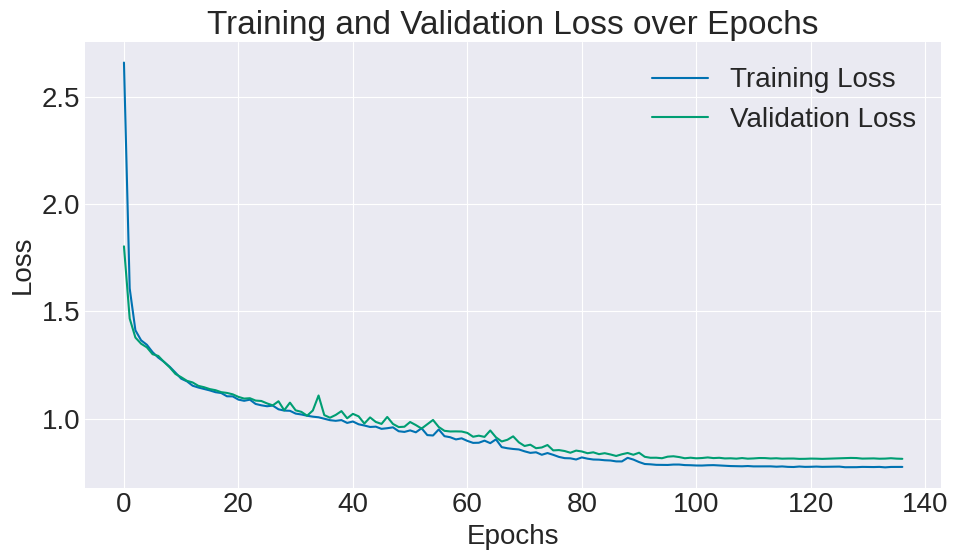

In [38]:
# 1. Create and plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('loss_plot.png')
plt.show()

### 6e. Questions

**Question 4:** Look over the addition prompts and generated answers for mistakes.

a. What types of mistakes do you spot?

b. How close are the mistakes to the true answers?

c. Why do you think the transformer is making the mistakes it makes?

*If your transformer is not making mistakes, print out more prompts/answers or cut the training off a little earlier so the final validation loss is higher.*

<br/><br/>

**Question 5:** Have some fun and prompt your trained transformer with hand crafted addition prompt strings. Try to "trick" your transformer:

a. using valid prompts (i.e. up to 2 digits per operand). 

b. using invalid prompts. 

In both cases document where it does well and where it does not with specific examples.

<br/><br/>

**Question 6:** Add the following code to your GPT's temporal cross entropy loss code: `print(tf.reshape(act_at_correct, (N, T)))` The line of code prints the softmax netAct values produced by the net's output layer from the neuron coding the correct next token. Adapt as necessary to make it print these expected values. Run the code provided below. In some detail, interpret why the netActs are high or low in each case and why that makes sense.

<br/><br/>

**Question 7:** Following up from the previous question, notice how the netActs for the 1st char are small yet nonzero in all cases. Why does this happen and explain why the loss cannot get to exactly 0. 

**When you are done running Q6 and Q7, comment out the print out in the `loss` method.**

<br/><br/>

**Question 8:** In the cell below, call `generate_sequence` on one of the transformers and plug in a single prompt that yields an incorrect answer based on the above validation set print outs. In your call to `generate_sequence`, set the keyword argument `plot_probs` to `True`. Use the plots of the output layer netActs to explain what is going on when the network predicts the incorrect answer.

**Answer 4:**
a. There are lots of off by one errors from the transformer, for example, "12+45=58" when it should be "57", or "3+14=16" when it should be "17", and similarly "38+40=79" instead of "78"

b. How close are the mistakes to the true answers?
Most errors are very close to the correct answer, typically off by just 1-2 units or involving a digit swap. This suggests the model has learned the general pattern of addition but struggles with precise calculations in certain cases.

c. Why is the transformer making these mistakes?
The transformer struggles with arithmetic because it doesn't implement true algorithmic reasoning, instead relying on statistical pattern recognition from limited training examples, which prevents it from generalizing perfectly to all addition combinations.

**Answer 5:**
A valid prompt I used was '2+11=' to which the transformer output '23'. This clearly is not the correct answer, however doing '11+2=' returned the correct answer of 13. I also tried the invalid prompt '2+2+2=' which contains multiple operators, and the transformer returned '50' which I thought was interesting, I'm not entirely sure how the second operator influenced the response but it made it seem to think there was a much larger number involved in the addition.

**Answer 6:**

**Answer 7:**

**Answer 8:**
Here, the plots are showing char is most likely to be predicted based on the softmax values output by the network. As seen in the plots, the first char predicted after '2+11=' with the highest value is 2, which is why it is selected. However, the model is somewhat right is selecting '3' next, as the correct answer would be 13. It also correctly ends the sequence with '.', so it knows that the result should be a two digit answer.

In [49]:
# Question 5
prompt = '11+2='
answer = picogpt_small.generate_sequence(prompt=prompt,
                                length=seq_len,
                                char2ind_map=char2ind_map,
                                ind2char_map=ind2char_map,
                                end_char='.')

prompt = '2+2+2='
answer = picogpt_small.generate_sequence(prompt=prompt,
                                length=seq_len,
                                char2ind_map=char2ind_map,
                                ind2char_map=ind2char_map,
                                end_char='.')

11+2=13.
2+2+2=50.


In [50]:
# Question 6 TODO: Replace in the code below:
# char2ind_map: with your char-to-int dictionary
# gpt_add1: with your trained net

prompts = [list('33+1=34.##'), list('33+10=43.#'), list('33+33=66.#')]
prompts_int_x, prompts_int_y = make_addition_samples_and_labels(prompts, char2ind_map)
prompts_int_x = tf.cast(prompts_int_x, tf.int32)
prompts_int_y = tf.cast(prompts_int_y, tf.int32)
net_acts = picogpt_small(prompts_int_x)
picogpt_small.loss(net_acts, prompts_int_y)


tf.Tensor(
[[0.1049 0.9999 0.117  0.0678 0.7921 0.6993 0.9997 0.9992 0.9999]
 [0.1049 0.9999 0.117  0.0946 1.     0.9936 0.8064 0.9994 0.9999]
 [0.1049 0.9999 0.1149 0.0811 0.9996 0.9902 0.5052 0.9999 0.9999]], shape=(3, 9), dtype=float32)


<tf.Tensor: shape=(), dtype=float32, numpy=0.82544523>

2+11=

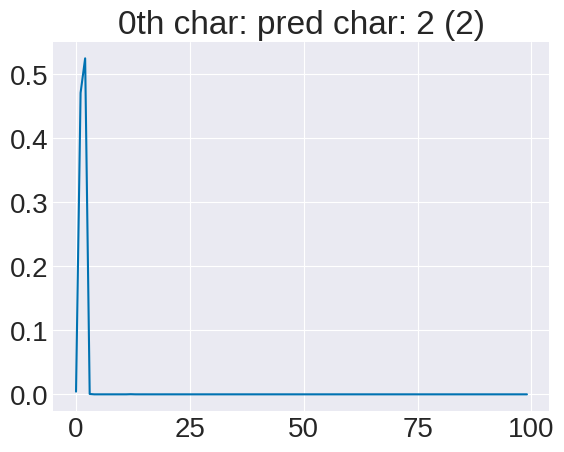

2

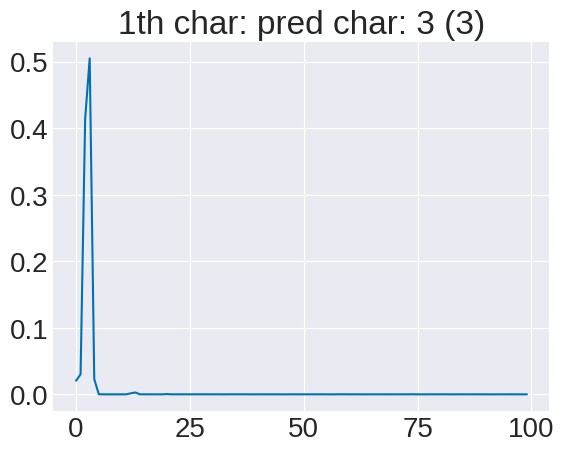

3

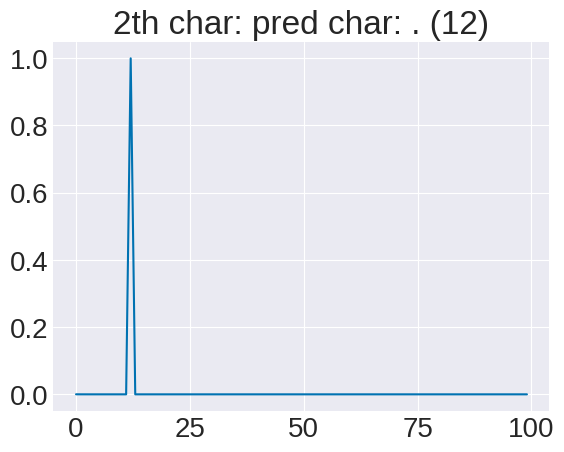

.


In [51]:
# Question 8.
# TODO: modify prompt to one that produces an incorrect output. Change any other variables to suit your conventions
prompt = '2+11='
answer = picogpt_small.generate_sequence(prompt=prompt,
                                length=seq_len,
                                char2ind_map=char2ind_map,
                                ind2char_map=ind2char_map,
                                end_char='.',
                                plot_probs=True)